## CNN Model

This notebook attempts to implement the CNN model for drug-drug interaction (DDI) sentence classification described in Suarez 2017 (doi:10.1093/database/bax019) without position embeddings. This model will be used as the basis for an ensemble model to explore its performance on DDI classification.  

In [22]:
import pickle
import itertools
import datetime
import re
import time
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.utils import shuffle
import keras
import nltk
import matplotlib.pyplot as plt

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import regularizers, backend
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Activation, Merge, Dense, Dropout
from keras.callbacks import Callback

In [23]:
def open_pickle(data):
    pickle_in = open(data, 'rb')
    return pickle.load(pickle_in)

def write_to_pickle(data, file_name):
    pickle_out = open(file_name, 'wb')
    pickle.dump(data, pickle_out)
    pickle_out.close()

In [24]:
train_data = open_pickle('./train_complete_processed.pickle')
test_data = open_pickle('./test_complete_processed.pickle')

### Pre-Modeling Tasks

#### Build Vocabulary

In [25]:
texts = train_data['tokenized_sentences'].tolist() + test_data['tokenized_sentences'].tolist()
vocabulary_size = 15000
vocabulary = Tokenizer(num_words = vocabulary_size)
vocabulary.fit_on_texts(texts)

#map of ids to words
reverse_vocabulary = dict(zip(vocabulary.word_index.values(), vocabulary.word_index.keys()))

def ids_to_string(ids):
    words = [reverse_vocabulary[id] for id in ids if id != 0]
    return " ".join(words)

#### Create One-Hot Vector Label Transformers

In [26]:
lb = LabelBinarizer()
label_transformer = deepcopy(lb.fit(train_data['ddi_type']))

#### Train/Validation Split

In [27]:
def train_validation_split(data, p = 0.15, max_length = 128):
    '''returns the a train/validation split of the data with a proportion p of the data being split off for the
    validation set
    
    returns: (x_train, y_train, x_dev, y_dev)
    
    x_train and x_dev are returned as  n by max_length arrays where n is the number of rows in each of the train
    and dev set after the split has been made
    
    y_train and y_dev are returned as n by 5 arrays where n is the number of rows in each of the train and dev set
    after the split has been made
    '''
    split_size = int(len(data)*p)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    dev = data.loc[indices[ :split_size], : ]
    train = data.loc[indices[split_size: ], : ]
    
    #convert to ids based on vocabulary and pad to max_length
    x_train_ids = vocabulary.texts_to_sequences(train['tokenized_sentences'])
    x_train = pad_sequences(x_train_ids, maxlen = max_length, padding = 'post', truncating = 'post')
    dev_train_ids = vocabulary.texts_to_sequences(dev['tokenized_sentences'])
    x_dev = pad_sequences(dev_train_ids, maxlen = max_length, padding = 'post', truncating = 'post')
    
    #tranform labels to one-hot vectors
    y_train = label_transformer.transform(train['ddi_type'])
    y_dev = label_transformer.transform(dev['ddi_type'])   
    
    return (x_train, y_train, x_dev, y_dev)

def convert_test_data(data, max_length = 128):
    '''
    Retruns the numerical representation of the sentences in the test set
    
    returns: (x_test, y_test)
    
    x_test is an n by max_length array where n is the number of rows in the test set
    y_test is an n by max_length array where n is the number of rows in the test set
    '''
    
    x_test_ids = vocabulary.texts_to_sequences(data['tokenized_sentences'])
    x_test = pad_sequences(x_test_ids, maxlen = max_length, padding = 'post', truncating = 'post')
    y_test = label_transformer.transform(data['ddi_type'])
    
    return (x_test, y_test)

In [195]:
x_train, y_train, x_dev, y_dev = train_validation_split(train_data, p = 0.15, max_length = 128)
x_test, y_test = convert_test_data(test_data)

#negatives of the test set that were filtered out from preprocessing
negatives = open_pickle('test_negatives_processed.pickle')
y_neg_true = label_transformer.transform(negatives['ddi_type'])
y_neg_predict = np.repeat(np.array([[0, 0, 0, 0, 1]]), repeats = len(negatives), axis = 0)

### Building the CNN Model

Following the parameters used by Suarez we train a CNN using the following; however, instead of using 3 different size filters of 3, 4, and 5, we only use a filter size of 3 for simplicity:
* Max length = 128
* ReLU activations
* Number of filters = 200
* L2-regularization (on the softmax layer) = 3
* Mini-batch size = 50
* Dropout rate = 0.5
* Embedding Layer: 300 dimensions with -1, +1 unifrom initialization
* Update rule: Adam

In [169]:
def to_one_hot(p):
    sess = tf.Session()
    with sess.as_default():
        one_hot= tf.one_hot(np.argmax(p, axis = 1), depth = 5, dtype = 'int32').eval()
        return one_hot

def to_labels(one_hot_vectors):
    '''takes an array of one hot vectors and converts them back to labels'''
    return label_transformer.inverse_transform(one_hot_vectors)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = backend.sum(y_true * backend.one_hot(backend.argmax(y_pred, 1), 5))
    possible_positives = backend.sum(y_true)
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = backend.sum(y_true * backend.one_hot(backend.argmax(y_pred, 1), 5))
    predicted_positives = backend.sum(backend.one_hot(backend.argmax(y_pred, 1), 5))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+backend.epsilon()))

def plot_confusion_matrix(true_values, predicted_values, title = 'Confusion Matrix'):
    cm = confusion_matrix(true_values, predicted_values)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center')
    plt.imshow(cm, cmap = plt.cm.Blues, alpha = 0)
    ticks = np.arange(5)
    plt.xticks(ticks, ['advise', 'effect', 'int', 'mechanism', 'none'], rotation = 45)
    plt.yticks(ticks, ['advise', 'effect', 'int', 'mechanism', 'none'])
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    return

class Metrics(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        
        def plot_confusion_matrix(true_values, predicted_values):
            cm = confusion_matrix(true_values, predicted_values)
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j],
                         horizontalalignment = 'center')
            plt.imshow(cm, cmap = plt.cm.Blues, alpha = 0)
            ticks = np.arange(5)
            plt.xticks(ticks, ['advise', 'effect', 'int', 'mechanism', 'none'], rotation = 45)
            plt.yticks(ticks, ['advise', 'effect', 'int', 'mechanism', 'none'])
            plt.tight_layout()
            plt.ylabel('True Label')
            plt.xlabel('Predicted label')
            plt.gcf().savefig(filename = f"F:/keras_checkpoints/filter_3/validation_confusion_matrices/confusion_matrix_epoch_{batch+1}.png", 
                              format = 'png',
                              pad_inches = 0.2)
            return plt.figure()
                
        predict = to_one_hot(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        self.f1s = f1_score(targ, predict, average = 'micro')
        #self.confusion_matrix = confusion_matrix()
        print(f'validation f1-score: {self.f1s}')
        
        if batch + 1 == 1 or (batch + 1) % 5 == 0:
            plt.title(f'Validation Confusion Matrix at Epoch {batch+1}')
            fig = plot_confusion_matrix(to_labels(targ), to_labels(predict))
            #plt.gcf().savefig(filename = f"F:/keras_checkpoints/filter_3/validation_confusion_matrices/confusion_matrix_epoch_{batch+1}.png", format = 'png')
            plt.show()
            
        return



In [30]:
#parameters
E = 300
max_length = 128
num_filters = 200
filter_size = 3
dropout_rate = 0.5
batch_size = 50
metrics = Metrics()
checkpointer = keras.callbacks.ModelCheckpoint(filepath = "F:/keras_checkpoints/filter_3/epoch_{epoch:02d}.hdf5")

In [31]:
unit_cnn = Sequential()
unit_cnn.add(Embedding(input_dim = vocabulary_size,
                       output_dim = E,
                       embeddings_initializer = keras.initializers.RandomUniform(minval=-1.00, maxval=1.00, seed=None),
                       input_length = max_length))
unit_cnn.add(Conv1D(filters = num_filters,
                    kernel_size = filter_size,
                    activation = 'relu',
                    kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)))
unit_cnn.add(GlobalMaxPooling1D())
unit_cnn.add(Dropout(rate = dropout_rate))
unit_cnn.add(Dense(units = 5,
                   activation = 'softmax',
                   kernel_regularizer = keras.regularizers.l2(3.0)))

unit_cnn.compile(optimizer = 'adam',
                 loss = 'categorical_crossentropy',
                 metrics = ['categorical_accuracy', f1])

Train on 15343 samples, validate on 2707 samples
Epoch 1/150
15343/15343 [==============================] - 72s 5ms/step - loss: 6.3943 - categorical_accuracy: 0.7487 - f1: 0.7487 - val_loss: 0.7364 - val_categorical_accuracy: 0.7787 - val_f1: 0.7787
validation f1-score: 0.7787218322866643


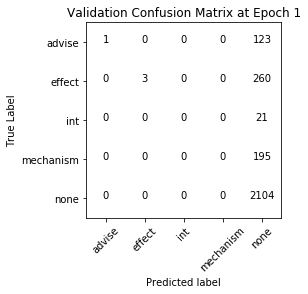

Epoch 2/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.7152 - categorical_accuracy: 0.7895 - f1: 0.7895 - val_loss: 0.6714 - val_categorical_accuracy: 0.7865 - val_f1: 0.7865
validation f1-score: 0.7864794975988179
Epoch 3/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.6726 - categorical_accuracy: 0.7964 - f1: 0.7964 - val_loss: 0.6315 - val_categorical_accuracy: 0.8072 - val_f1: 0.8072
validation f1-score: 0.8071666050978944
Epoch 4/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.6395 - categorical_accuracy: 0.8062 - f1: 0.8062 - val_loss: 0.6196 - val_categorical_accuracy: 0.7924 - val_f1: 0.7924
validation f1-score: 0.7923900997414112
Epoch 5/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.5996 - categorical_accuracy: 0.8135 - f1: 0.8135 - val_loss: 0.6035 - val_categorical_accuracy: 0.7924 - val_f1: 0.7924
validation f1-score: 0.7923900997414112


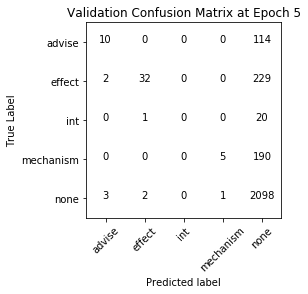

Epoch 6/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.5712 - categorical_accuracy: 0.8248 - f1: 0.8248 - val_loss: 0.5604 - val_categorical_accuracy: 0.8138 - val_f1: 0.8138
validation f1-score: 0.8138160325083119
Epoch 7/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.5439 - categorical_accuracy: 0.8322 - f1: 0.8322 - val_loss: 0.5736 - val_categorical_accuracy: 0.8079 - val_f1: 0.8079
validation f1-score: 0.8079054303657185
Epoch 8/150
15343/15343 [==============================] - 69s 5ms/step - loss: 0.5247 - categorical_accuracy: 0.8391 - f1: 0.8391 - val_loss: 0.4864 - val_categorical_accuracy: 0.8445 - val_f1: 0.8445
validation f1-score: 0.8444772811230145
Epoch 9/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.4890 - categorical_accuracy: 0.8509 - f1: 0.8509 - val_loss: 0.4821 - val_categorical_accuracy: 0.8545 - val_f1: 0.8545
validation f1-score: 0.8544514222386406
Epoch 10/150
15343/15343 [======

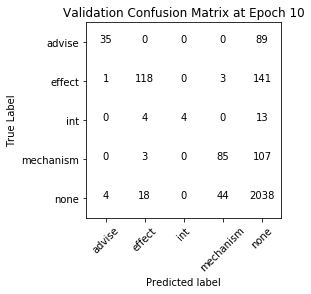

Epoch 11/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.4527 - categorical_accuracy: 0.8616 - f1: 0.8616 - val_loss: 0.4591 - val_categorical_accuracy: 0.8567 - val_f1: 0.8567
validation f1-score: 0.8566678980421131
Epoch 12/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.4395 - categorical_accuracy: 0.8680 - f1: 0.8680 - val_loss: 0.4360 - val_categorical_accuracy: 0.8548 - val_f1: 0.8548
validation f1-score: 0.8548208348725527
Epoch 13/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.4144 - categorical_accuracy: 0.8753 - f1: 0.8753 - val_loss: 0.4327 - val_categorical_accuracy: 0.8585 - val_f1: 0.8585
validation f1-score: 0.8585149612116735
Epoch 14/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.4051 - categorical_accuracy: 0.8831 - f1: 0.8831 - val_loss: 0.4452 - val_categorical_accuracy: 0.8622 - val_f1: 0.8622
validation f1-score: 0.8622090875507943
Epoch 15/150
15343/15343 [==

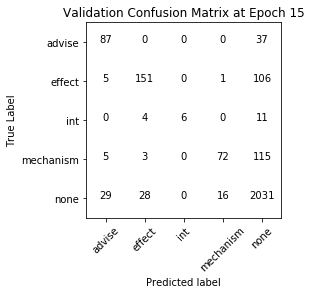

Epoch 16/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.3751 - categorical_accuracy: 0.8875 - f1: 0.8875 - val_loss: 0.4215 - val_categorical_accuracy: 0.8678 - val_f1: 0.8678
validation f1-score: 0.8677502770594754
Epoch 17/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.3663 - categorical_accuracy: 0.8955 - f1: 0.8955 - val_loss: 0.4106 - val_categorical_accuracy: 0.8703 - val_f1: 0.8703
validation f1-score: 0.87033616549686
Epoch 18/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.3483 - categorical_accuracy: 0.8998 - f1: 0.8998 - val_loss: 0.4771 - val_categorical_accuracy: 0.8596 - val_f1: 0.8596
validation f1-score: 0.8596231991134097
Epoch 19/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.3391 - categorical_accuracy: 0.9030 - f1: 0.9030 - val_loss: 0.4029 - val_categorical_accuracy: 0.8711 - val_f1: 0.8711
validation f1-score: 0.8710749907646842
Epoch 20/150
15343/15343 [====

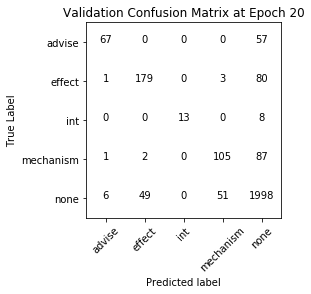

Epoch 21/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.3300 - categorical_accuracy: 0.9080 - f1: 0.9080 - val_loss: 0.5897 - val_categorical_accuracy: 0.8375 - val_f1: 0.8375
validation f1-score: 0.837458441078685
Epoch 22/150
15343/15343 [==============================] - 77s 5ms/step - loss: 0.3207 - categorical_accuracy: 0.9119 - f1: 0.9119 - val_loss: 0.4156 - val_categorical_accuracy: 0.8696 - val_f1: 0.8696
validation f1-score: 0.8695973402290358
Epoch 23/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.3109 - categorical_accuracy: 0.9125 - f1: 0.9125 - val_loss: 0.4191 - val_categorical_accuracy: 0.8700 - val_f1: 0.8700
validation f1-score: 0.8699667528629479
Epoch 24/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.3131 - categorical_accuracy: 0.9141 - f1: 0.9141 - val_loss: 0.4624 - val_categorical_accuracy: 0.8707 - val_f1: 0.8707
validation f1-score: 0.870705578130772
Epoch 25/150
15343/15343 [====

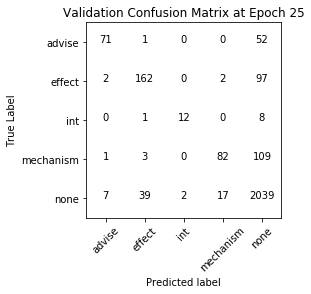

Epoch 26/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2949 - categorical_accuracy: 0.9182 - f1: 0.9182 - val_loss: 0.4259 - val_categorical_accuracy: 0.8740 - val_f1: 0.8740
validation f1-score: 0.8740302918359808
Epoch 27/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2925 - categorical_accuracy: 0.9196 - f1: 0.9196 - val_loss: 0.4637 - val_categorical_accuracy: 0.8689 - val_f1: 0.8689
validation f1-score: 0.8688585149612117
Epoch 28/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2854 - categorical_accuracy: 0.9208 - f1: 0.9208 - val_loss: 0.4243 - val_categorical_accuracy: 0.8707 - val_f1: 0.8707
validation f1-score: 0.870705578130772
Epoch 29/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2851 - categorical_accuracy: 0.9213 - f1: 0.9213 - val_loss: 0.4984 - val_categorical_accuracy: 0.8526 - val_f1: 0.8526
validation f1-score: 0.8526043590690802
Epoch 30/150
15343/15343 [===

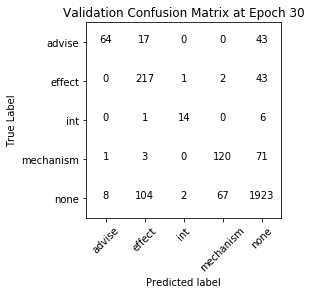

Epoch 31/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2768 - categorical_accuracy: 0.9245 - f1: 0.9245 - val_loss: 0.4523 - val_categorical_accuracy: 0.8759 - val_f1: 0.8759
validation f1-score: 0.8758773550055412
Epoch 32/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2765 - categorical_accuracy: 0.9247 - f1: 0.9247 - val_loss: 0.4447 - val_categorical_accuracy: 0.8685 - val_f1: 0.8685
validation f1-score: 0.8684891023272996
Epoch 33/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2694 - categorical_accuracy: 0.9252 - f1: 0.9252 - val_loss: 0.4427 - val_categorical_accuracy: 0.8685 - val_f1: 0.8685
validation f1-score: 0.8684891023272996
Epoch 34/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2673 - categorical_accuracy: 0.9271 - f1: 0.9271 - val_loss: 0.4800 - val_categorical_accuracy: 0.8589 - val_f1: 0.8589
validation f1-score: 0.8588843738455855
Epoch 35/150
15343/15343 [==

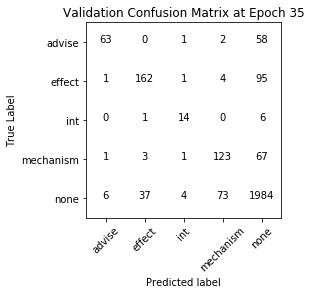

Epoch 36/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2637 - categorical_accuracy: 0.9286 - f1: 0.9286 - val_loss: 0.4547 - val_categorical_accuracy: 0.8629 - val_f1: 0.8629
validation f1-score: 0.8629479128186184
Epoch 37/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2598 - categorical_accuracy: 0.9324 - f1: 0.9324 - val_loss: 0.4459 - val_categorical_accuracy: 0.8770 - val_f1: 0.8770
validation f1-score: 0.8769855929072774
Epoch 38/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2544 - categorical_accuracy: 0.9311 - f1: 0.9311 - val_loss: 0.4807 - val_categorical_accuracy: 0.8714 - val_f1: 0.8714
validation f1-score: 0.8714444033985962
Epoch 39/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2580 - categorical_accuracy: 0.9299 - f1: 0.9299 - val_loss: 0.4540 - val_categorical_accuracy: 0.8707 - val_f1: 0.8707
validation f1-score: 0.870705578130772
Epoch 40/150
15343/15343 [===

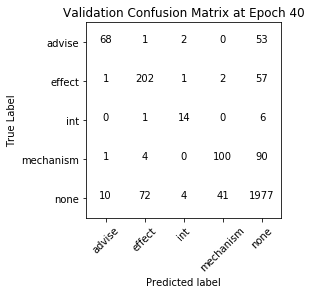

Epoch 41/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2470 - categorical_accuracy: 0.9328 - f1: 0.9328 - val_loss: 0.4865 - val_categorical_accuracy: 0.8740 - val_f1: 0.8740
validation f1-score: 0.8740302918359808
Epoch 42/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2605 - categorical_accuracy: 0.9310 - f1: 0.9310 - val_loss: 0.5412 - val_categorical_accuracy: 0.8485 - val_f1: 0.8485
validation f1-score: 0.8485408200960473
Epoch 43/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2467 - categorical_accuracy: 0.9323 - f1: 0.9323 - val_loss: 0.4717 - val_categorical_accuracy: 0.8666 - val_f1: 0.8666
validation f1-score: 0.8666420391577392
Epoch 44/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2558 - categorical_accuracy: 0.9323 - f1: 0.9323 - val_loss: 0.4853 - val_categorical_accuracy: 0.8615 - val_f1: 0.8615
validation f1-score: 0.8614702622829701
Epoch 45/150
15343/15343 [==

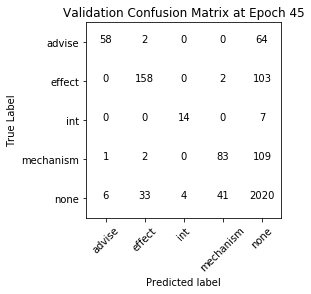

Epoch 46/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2438 - categorical_accuracy: 0.9342 - f1: 0.9342 - val_loss: 0.5359 - val_categorical_accuracy: 0.8629 - val_f1: 0.8629
validation f1-score: 0.8629479128186184
Epoch 47/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2420 - categorical_accuracy: 0.9355 - f1: 0.9355 - val_loss: 0.5100 - val_categorical_accuracy: 0.8596 - val_f1: 0.8596
validation f1-score: 0.8596231991134097
Epoch 48/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2441 - categorical_accuracy: 0.9346 - f1: 0.9346 - val_loss: 0.5322 - val_categorical_accuracy: 0.8611 - val_f1: 0.8611
validation f1-score: 0.861100849649058
Epoch 49/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2439 - categorical_accuracy: 0.9361 - f1: 0.9361 - val_loss: 0.4843 - val_categorical_accuracy: 0.8655 - val_f1: 0.8655
validation f1-score: 0.865533801256003
Epoch 50/150
15343/15343 [====

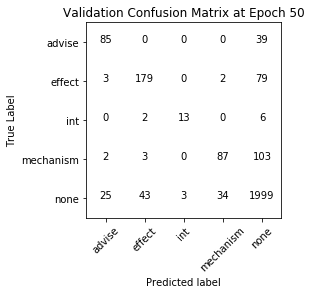

Epoch 51/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2414 - categorical_accuracy: 0.9344 - f1: 0.9344 - val_loss: 0.5109 - val_categorical_accuracy: 0.8718 - val_f1: 0.8718
validation f1-score: 0.8718138160325083
Epoch 52/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2386 - categorical_accuracy: 0.9350 - f1: 0.9350 - val_loss: 0.4825 - val_categorical_accuracy: 0.8685 - val_f1: 0.8685
validation f1-score: 0.8684891023272996
Epoch 53/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2370 - categorical_accuracy: 0.9368 - f1: 0.9368 - val_loss: 0.5165 - val_categorical_accuracy: 0.8611 - val_f1: 0.8611
validation f1-score: 0.861100849649058
Epoch 54/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2321 - categorical_accuracy: 0.9378 - f1: 0.9378 - val_loss: 0.5526 - val_categorical_accuracy: 0.8726 - val_f1: 0.8726
validation f1-score: 0.8725526413003325
Epoch 55/150
15343/15343 [===

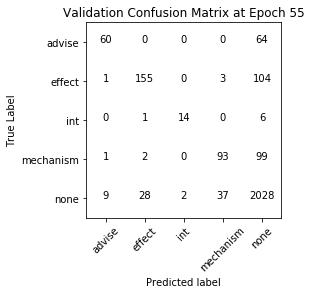

Epoch 56/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2326 - categorical_accuracy: 0.9368 - f1: 0.9368 - val_loss: 0.4981 - val_categorical_accuracy: 0.8674 - val_f1: 0.8674
validation f1-score: 0.8673808644255634
Epoch 57/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2285 - categorical_accuracy: 0.9400 - f1: 0.9400 - val_loss: 0.5485 - val_categorical_accuracy: 0.8707 - val_f1: 0.8707
validation f1-score: 0.870705578130772
Epoch 58/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2220 - categorical_accuracy: 0.9391 - f1: 0.9391 - val_loss: 0.4936 - val_categorical_accuracy: 0.8700 - val_f1: 0.8700
validation f1-score: 0.8699667528629479
Epoch 59/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2299 - categorical_accuracy: 0.9380 - f1: 0.9380 - val_loss: 0.5796 - val_categorical_accuracy: 0.8722 - val_f1: 0.8722
validation f1-score: 0.8721832286664204
Epoch 60/150
15343/15343 [===

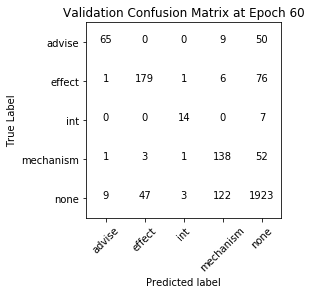

Epoch 61/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2304 - categorical_accuracy: 0.9402 - f1: 0.9402 - val_loss: 0.5640 - val_categorical_accuracy: 0.8711 - val_f1: 0.8711
validation f1-score: 0.8710749907646842
Epoch 62/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2296 - categorical_accuracy: 0.9384 - f1: 0.9384 - val_loss: 0.5478 - val_categorical_accuracy: 0.8714 - val_f1: 0.8714
validation f1-score: 0.8714444033985962
Epoch 63/150
15343/15343 [==============================] - 69s 5ms/step - loss: 0.2340 - categorical_accuracy: 0.9371 - f1: 0.9371 - val_loss: 0.5347 - val_categorical_accuracy: 0.8622 - val_f1: 0.8622
validation f1-score: 0.8622090875507943
Epoch 64/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2244 - categorical_accuracy: 0.9394 - f1: 0.9394 - val_loss: 0.5830 - val_categorical_accuracy: 0.8456 - val_f1: 0.8456
validation f1-score: 0.8455855190247507
Epoch 65/150
15343/15343 [==

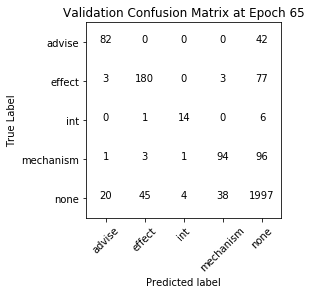

Epoch 66/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2166 - categorical_accuracy: 0.9423 - f1: 0.9423 - val_loss: 0.6258 - val_categorical_accuracy: 0.8674 - val_f1: 0.8674
validation f1-score: 0.8673808644255634
Epoch 67/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.2268 - categorical_accuracy: 0.9389 - f1: 0.9389 - val_loss: 0.5988 - val_categorical_accuracy: 0.8729 - val_f1: 0.8729
validation f1-score: 0.8729220539342446
Epoch 68/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2215 - categorical_accuracy: 0.9413 - f1: 0.9413 - val_loss: 0.5780 - val_categorical_accuracy: 0.8460 - val_f1: 0.8460
validation f1-score: 0.8459549316586628
Epoch 69/150
15343/15343 [==============================] - 70s 5ms/step - loss: 0.2245 - categorical_accuracy: 0.9436 - f1: 0.9436 - val_loss: 0.5887 - val_categorical_accuracy: 0.8714 - val_f1: 0.8714
validation f1-score: 0.8714444033985962
Epoch 70/150
15343/15343 [==

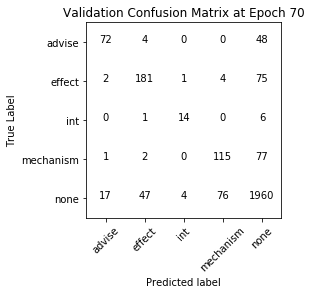

Epoch 71/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2228 - categorical_accuracy: 0.9404 - f1: 0.9404 - val_loss: 0.5691 - val_categorical_accuracy: 0.8655 - val_f1: 0.8655
validation f1-score: 0.865533801256003
Epoch 72/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.2218 - categorical_accuracy: 0.9422 - f1: 0.9422 - val_loss: 0.5717 - val_categorical_accuracy: 0.8663 - val_f1: 0.8663
validation f1-score: 0.8662726265238271
Epoch 73/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2152 - categorical_accuracy: 0.9435 - f1: 0.9435 - val_loss: 0.6381 - val_categorical_accuracy: 0.8622 - val_f1: 0.8622
validation f1-score: 0.8622090875507943
Epoch 74/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2098 - categorical_accuracy: 0.9443 - f1: 0.9443 - val_loss: 0.5774 - val_categorical_accuracy: 0.8593 - val_f1: 0.8593
validation f1-score: 0.8592537864794977
Epoch 75/150
15343/15343 [===

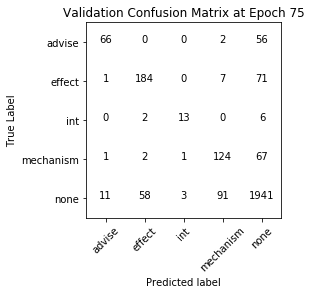

Epoch 76/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2277 - categorical_accuracy: 0.9412 - f1: 0.9412 - val_loss: 0.5577 - val_categorical_accuracy: 0.8641 - val_f1: 0.8641
validation f1-score: 0.8640561507203547
Epoch 77/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2134 - categorical_accuracy: 0.9421 - f1: 0.9421 - val_loss: 0.6187 - val_categorical_accuracy: 0.8563 - val_f1: 0.8563
validation f1-score: 0.856298485408201
Epoch 78/150
15343/15343 [==============================] - 76s 5ms/step - loss: 0.2208 - categorical_accuracy: 0.9426 - f1: 0.9426 - val_loss: 0.5878 - val_categorical_accuracy: 0.8578 - val_f1: 0.8578
validation f1-score: 0.8577761359438493
Epoch 79/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2016 - categorical_accuracy: 0.9484 - f1: 0.9484 - val_loss: 0.6021 - val_categorical_accuracy: 0.8681 - val_f1: 0.8681
validation f1-score: 0.8681196896933875
Epoch 80/150
15343/15343 [===

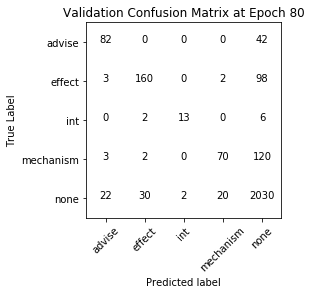

Epoch 81/150
15343/15343 [==============================] - 79s 5ms/step - loss: 0.2154 - categorical_accuracy: 0.9445 - f1: 0.9445 - val_loss: 0.5557 - val_categorical_accuracy: 0.8600 - val_f1: 0.8600
validation f1-score: 0.8599926117473218
Epoch 82/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2146 - categorical_accuracy: 0.9422 - f1: 0.9422 - val_loss: 0.6098 - val_categorical_accuracy: 0.8515 - val_f1: 0.8515
validation f1-score: 0.851496121167344
Epoch 83/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2223 - categorical_accuracy: 0.9428 - f1: 0.9428 - val_loss: 0.5893 - val_categorical_accuracy: 0.8519 - val_f1: 0.8519
validation f1-score: 0.851865533801256
Epoch 84/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2131 - categorical_accuracy: 0.9430 - f1: 0.9430 - val_loss: 0.6244 - val_categorical_accuracy: 0.8652 - val_f1: 0.8652
validation f1-score: 0.8651643886220909
Epoch 85/150
15343/15343 [====

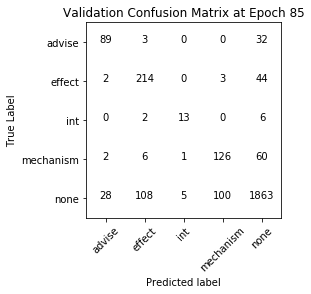

Epoch 86/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2160 - categorical_accuracy: 0.9431 - f1: 0.9431 - val_loss: 0.6332 - val_categorical_accuracy: 0.8511 - val_f1: 0.8511
validation f1-score: 0.8511267085334319
Epoch 87/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2082 - categorical_accuracy: 0.9458 - f1: 0.9458 - val_loss: 0.6378 - val_categorical_accuracy: 0.8589 - val_f1: 0.8589
validation f1-score: 0.8588843738455855
Epoch 88/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.2091 - categorical_accuracy: 0.9443 - f1: 0.9443 - val_loss: 0.5863 - val_categorical_accuracy: 0.8637 - val_f1: 0.8637
validation f1-score: 0.8636867380864426
Epoch 89/150
15343/15343 [==============================] - 73s 5ms/step - loss: 0.2168 - categorical_accuracy: 0.9443 - f1: 0.9443 - val_loss: 0.6087 - val_categorical_accuracy: 0.8607 - val_f1: 0.8607
validation f1-score: 0.8607314370151459
Epoch 90/150
15343/15343 [==

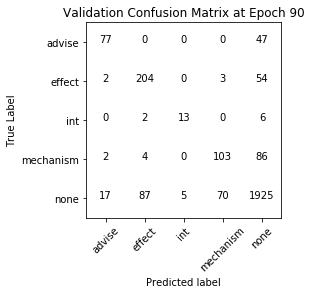

Epoch 91/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2054 - categorical_accuracy: 0.9451 - f1: 0.9451 - val_loss: 0.5954 - val_categorical_accuracy: 0.8578 - val_f1: 0.8578
validation f1-score: 0.8577761359438493
Epoch 92/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2050 - categorical_accuracy: 0.9471 - f1: 0.9471 - val_loss: 0.6211 - val_categorical_accuracy: 0.8581 - val_f1: 0.8581
validation f1-score: 0.8581455485777615
Epoch 93/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2117 - categorical_accuracy: 0.9425 - f1: 0.9425 - val_loss: 0.6719 - val_categorical_accuracy: 0.8585 - val_f1: 0.8585
validation f1-score: 0.8585149612116735
Epoch 94/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2148 - categorical_accuracy: 0.9447 - f1: 0.9447 - val_loss: 0.6707 - val_categorical_accuracy: 0.8596 - val_f1: 0.8596
validation f1-score: 0.8596231991134097
Epoch 95/150
15343/15343 [==

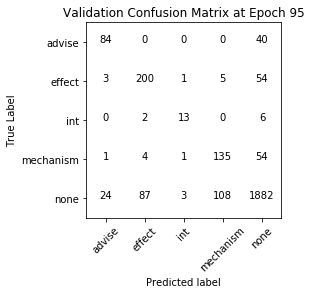

Epoch 96/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2055 - categorical_accuracy: 0.9470 - f1: 0.9470 - val_loss: 0.6055 - val_categorical_accuracy: 0.8567 - val_f1: 0.8567
validation f1-score: 0.8566678980421131
Epoch 97/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2060 - categorical_accuracy: 0.9432 - f1: 0.9432 - val_loss: 0.6281 - val_categorical_accuracy: 0.8611 - val_f1: 0.8611
validation f1-score: 0.861100849649058
Epoch 98/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2102 - categorical_accuracy: 0.9453 - f1: 0.9453 - val_loss: 0.6298 - val_categorical_accuracy: 0.8559 - val_f1: 0.8559
validation f1-score: 0.8559290727742888
Epoch 99/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2053 - categorical_accuracy: 0.9461 - f1: 0.9461 - val_loss: 0.6988 - val_categorical_accuracy: 0.8615 - val_f1: 0.8615
validation f1-score: 0.8614702622829701
Epoch 100/150
15343/15343 [==

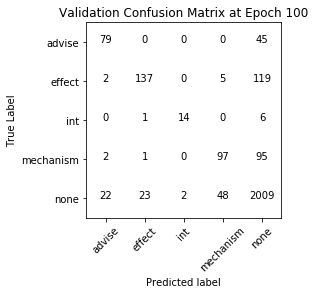

Epoch 101/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2238 - categorical_accuracy: 0.9423 - f1: 0.9423 - val_loss: 0.6890 - val_categorical_accuracy: 0.8678 - val_f1: 0.8678
validation f1-score: 0.8677502770594754
Epoch 102/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2086 - categorical_accuracy: 0.9455 - f1: 0.9455 - val_loss: 0.6598 - val_categorical_accuracy: 0.8581 - val_f1: 0.8581
validation f1-score: 0.8581455485777615
Epoch 103/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2078 - categorical_accuracy: 0.9451 - f1: 0.9451 - val_loss: 0.6795 - val_categorical_accuracy: 0.8618 - val_f1: 0.8618
validation f1-score: 0.8618396749168822
Epoch 104/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2059 - categorical_accuracy: 0.9453 - f1: 0.9453 - val_loss: 0.6268 - val_categorical_accuracy: 0.8570 - val_f1: 0.8570
validation f1-score: 0.8570373106760251
Epoch 105/150
15343/1534

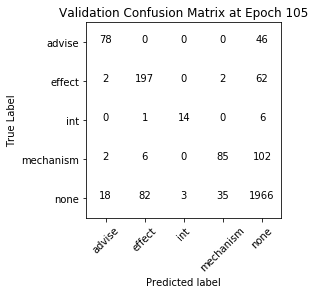

Epoch 106/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2108 - categorical_accuracy: 0.9431 - f1: 0.9431 - val_loss: 0.6674 - val_categorical_accuracy: 0.8556 - val_f1: 0.8556
validation f1-score: 0.8555596601403768
Epoch 107/150
15343/15343 [==============================] - 73s 5ms/step - loss: 0.2001 - categorical_accuracy: 0.9485 - f1: 0.9485 - val_loss: 0.6796 - val_categorical_accuracy: 0.8618 - val_f1: 0.8618
validation f1-score: 0.8618396749168822
Epoch 108/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2098 - categorical_accuracy: 0.9477 - f1: 0.9477 - val_loss: 0.6815 - val_categorical_accuracy: 0.8626 - val_f1: 0.8626
validation f1-score: 0.8625785001847063
Epoch 109/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2083 - categorical_accuracy: 0.9460 - f1: 0.9460 - val_loss: 0.6575 - val_categorical_accuracy: 0.8622 - val_f1: 0.8622
validation f1-score: 0.8622090875507943
Epoch 110/150
15343/1534

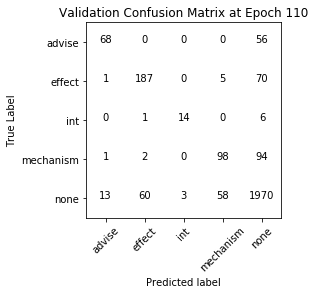

Epoch 111/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2086 - categorical_accuracy: 0.9472 - f1: 0.9472 - val_loss: 0.7953 - val_categorical_accuracy: 0.8629 - val_f1: 0.8629
validation f1-score: 0.8629479128186184
Epoch 112/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2074 - categorical_accuracy: 0.9454 - f1: 0.9454 - val_loss: 0.7746 - val_categorical_accuracy: 0.8637 - val_f1: 0.8637
validation f1-score: 0.8636867380864426
Epoch 113/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2013 - categorical_accuracy: 0.9455 - f1: 0.9455 - val_loss: 0.7049 - val_categorical_accuracy: 0.8463 - val_f1: 0.8463
validation f1-score: 0.8463243442925749
Epoch 114/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2025 - categorical_accuracy: 0.9466 - f1: 0.9466 - val_loss: 0.6681 - val_categorical_accuracy: 0.8519 - val_f1: 0.8519
validation f1-score: 0.851865533801256
Epoch 115/150
15343/15343

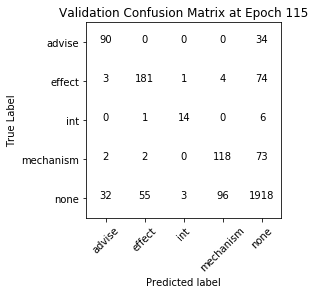

Epoch 116/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2084 - categorical_accuracy: 0.9466 - f1: 0.9466 - val_loss: 0.6934 - val_categorical_accuracy: 0.8604 - val_f1: 0.8604
validation f1-score: 0.8603620243812339
Epoch 117/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2141 - categorical_accuracy: 0.9453 - f1: 0.9453 - val_loss: 0.7621 - val_categorical_accuracy: 0.8589 - val_f1: 0.8589
validation f1-score: 0.8588843738455855
Epoch 118/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.1983 - categorical_accuracy: 0.9475 - f1: 0.9475 - val_loss: 0.7327 - val_categorical_accuracy: 0.8545 - val_f1: 0.8545
validation f1-score: 0.8544514222386406
Epoch 119/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2022 - categorical_accuracy: 0.9478 - f1: 0.9478 - val_loss: 0.8278 - val_categorical_accuracy: 0.8700 - val_f1: 0.8700
validation f1-score: 0.8699667528629479
Epoch 120/150
15343/1534

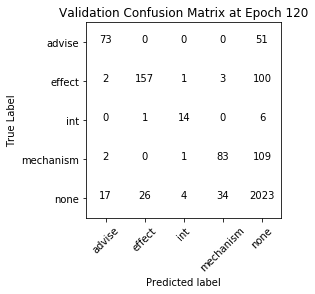

Epoch 121/150
15343/15343 [==============================] - 73s 5ms/step - loss: 0.1913 - categorical_accuracy: 0.9500 - f1: 0.9500 - val_loss: 0.7294 - val_categorical_accuracy: 0.8655 - val_f1: 0.8655
validation f1-score: 0.865533801256003
Epoch 122/150
15343/15343 [==============================] - 76s 5ms/step - loss: 0.1990 - categorical_accuracy: 0.9481 - f1: 0.9481 - val_loss: 0.6648 - val_categorical_accuracy: 0.8648 - val_f1: 0.8648
validation f1-score: 0.8647949759881788
Epoch 123/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.1978 - categorical_accuracy: 0.9469 - f1: 0.9469 - val_loss: 0.7092 - val_categorical_accuracy: 0.8585 - val_f1: 0.8585
validation f1-score: 0.8585149612116735
Epoch 124/150
15343/15343 [==============================] - 71s 5ms/step - loss: 0.2086 - categorical_accuracy: 0.9463 - f1: 0.9463 - val_loss: 0.6953 - val_categorical_accuracy: 0.8463 - val_f1: 0.8463
validation f1-score: 0.8463243442925749
Epoch 125/150
15343/15343

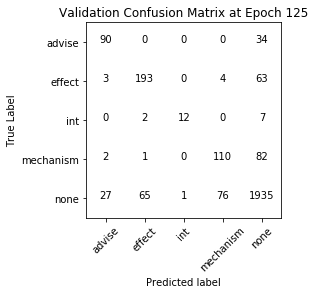

Epoch 126/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.1975 - categorical_accuracy: 0.9506 - f1: 0.9506 - val_loss: 0.7288 - val_categorical_accuracy: 0.8637 - val_f1: 0.8637
validation f1-score: 0.8636867380864426
Epoch 127/150
15343/15343 [==============================] - 73s 5ms/step - loss: 0.1993 - categorical_accuracy: 0.9477 - f1: 0.9477 - val_loss: 0.7676 - val_categorical_accuracy: 0.8567 - val_f1: 0.8567
validation f1-score: 0.8566678980421131
Epoch 128/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2036 - categorical_accuracy: 0.9484 - f1: 0.9484 - val_loss: 0.7472 - val_categorical_accuracy: 0.8548 - val_f1: 0.8548
validation f1-score: 0.8548208348725527
Epoch 129/150
15343/15343 [==============================] - 73s 5ms/step - loss: 0.2020 - categorical_accuracy: 0.9469 - f1: 0.9469 - val_loss: 0.7157 - val_categorical_accuracy: 0.8563 - val_f1: 0.8563
validation f1-score: 0.856298485408201
Epoch 130/150
15343/15343

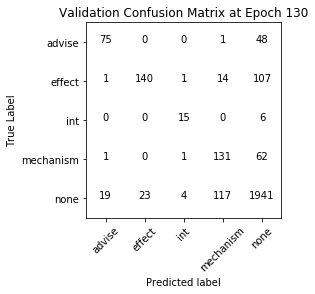

Epoch 131/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.1943 - categorical_accuracy: 0.9501 - f1: 0.9501 - val_loss: 0.6947 - val_categorical_accuracy: 0.8585 - val_f1: 0.8585
validation f1-score: 0.8585149612116735
Epoch 132/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2002 - categorical_accuracy: 0.9481 - f1: 0.9481 - val_loss: 0.7304 - val_categorical_accuracy: 0.8545 - val_f1: 0.8545
validation f1-score: 0.8544514222386406
Epoch 133/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2041 - categorical_accuracy: 0.9471 - f1: 0.9471 - val_loss: 0.7152 - val_categorical_accuracy: 0.8633 - val_f1: 0.8633
validation f1-score: 0.8633173254525304
Epoch 134/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2011 - categorical_accuracy: 0.9497 - f1: 0.9497 - val_loss: 0.7485 - val_categorical_accuracy: 0.8511 - val_f1: 0.8511
validation f1-score: 0.8511267085334319
Epoch 135/150
15343/1534

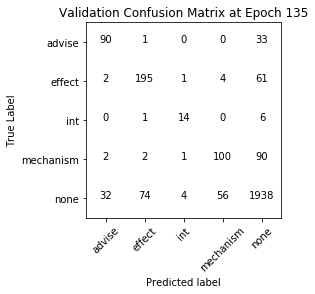

Epoch 136/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.1958 - categorical_accuracy: 0.9505 - f1: 0.9505 - val_loss: 0.8581 - val_categorical_accuracy: 0.8618 - val_f1: 0.8618
validation f1-score: 0.8618396749168822
Epoch 137/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.1963 - categorical_accuracy: 0.9497 - f1: 0.9497 - val_loss: 0.7303 - val_categorical_accuracy: 0.8533 - val_f1: 0.8533
validation f1-score: 0.8533431843369044
Epoch 138/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.1987 - categorical_accuracy: 0.9490 - f1: 0.9490 - val_loss: 0.7670 - val_categorical_accuracy: 0.8600 - val_f1: 0.8600
validation f1-score: 0.8599926117473218
Epoch 139/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2005 - categorical_accuracy: 0.9489 - f1: 0.9489 - val_loss: 0.7521 - val_categorical_accuracy: 0.8655 - val_f1: 0.8655
validation f1-score: 0.865533801256003
Epoch 140/150
15343/15343

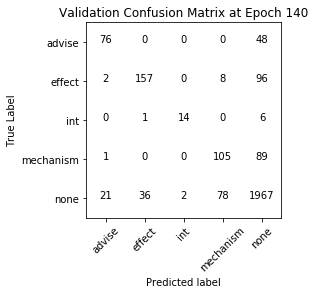

Epoch 141/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.1966 - categorical_accuracy: 0.9496 - f1: 0.9496 - val_loss: 0.7957 - val_categorical_accuracy: 0.8663 - val_f1: 0.8663
validation f1-score: 0.8662726265238271
Epoch 142/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.2021 - categorical_accuracy: 0.9478 - f1: 0.9478 - val_loss: 0.7808 - val_categorical_accuracy: 0.8426 - val_f1: 0.8426
validation f1-score: 0.842630217953454
Epoch 143/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.1984 - categorical_accuracy: 0.9487 - f1: 0.9487 - val_loss: 0.7708 - val_categorical_accuracy: 0.8629 - val_f1: 0.8629
validation f1-score: 0.8629479128186184
Epoch 144/150
15343/15343 [==============================] - 74s 5ms/step - loss: 0.1968 - categorical_accuracy: 0.9500 - f1: 0.9500 - val_loss: 0.7603 - val_categorical_accuracy: 0.8611 - val_f1: 0.8611
validation f1-score: 0.861100849649058
Epoch 145/150
15343/15343 

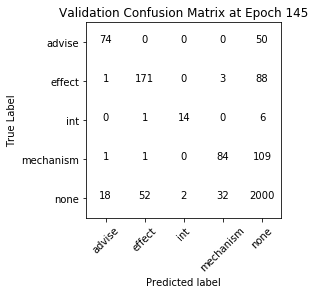

Epoch 146/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.2013 - categorical_accuracy: 0.9488 - f1: 0.9488 - val_loss: 0.8171 - val_categorical_accuracy: 0.8629 - val_f1: 0.8629
validation f1-score: 0.8629479128186184
Epoch 147/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.1977 - categorical_accuracy: 0.9486 - f1: 0.9486 - val_loss: 0.7726 - val_categorical_accuracy: 0.8548 - val_f1: 0.8548
validation f1-score: 0.8548208348725527
Epoch 148/150
15343/15343 [==============================] - 72s 5ms/step - loss: 0.2066 - categorical_accuracy: 0.9477 - f1: 0.9477 - val_loss: 0.7437 - val_categorical_accuracy: 0.8578 - val_f1: 0.8578
validation f1-score: 0.8577761359438493
Epoch 149/150
15343/15343 [==============================] - 75s 5ms/step - loss: 0.1990 - categorical_accuracy: 0.9486 - f1: 0.9486 - val_loss: 0.7401 - val_categorical_accuracy: 0.8659 - val_f1: 0.8659
validation f1-score: 0.865903213889915
Epoch 150/150
15343/15343

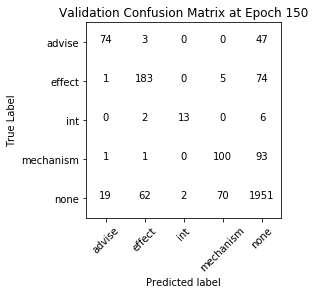

In [32]:
history = unit_cnn.fit(x_train, 
             y_train, 
             batch_size = batch_size, 
             epochs = 150,
             validation_data = (x_dev, y_dev),
             callbacks = [metrics, checkpointer])

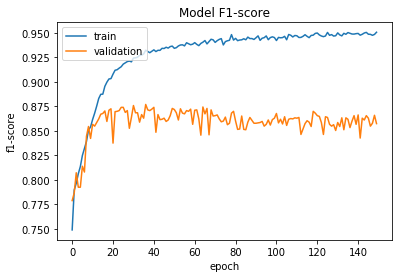

In [37]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1-score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.gcf().savefig(filename = "f1_training.png", 
                              format = 'png',
                              pad_inches = 0.2)
plt.show()

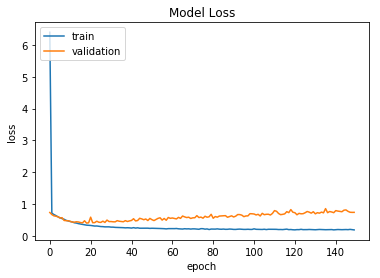

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.gcf().savefig(filename = "model_loss.png", 
                              format = 'png',
                              pad_inches = 0.2)
plt.show()

Based on the F1-score and Loss graphs, the optimal number of epochs to train for seems to be around 20. In the F1-score training graph, we see a large dropoff at epoch 20 likely due to random variation so we examine epoch 19 instead and its performance on the test data.

In [69]:
unit_cnn_19 = keras.models.load_model("F:/keras_checkpoints/filter_3/epoch_19.hdf5", custom_objects = {'f1': f1})

In [199]:
predictions = unit_cnn_19.predict(x_test, batch_size = 50)
predictions = to_one_hot(predictions)
predictions = to_labels(predictions)
true_labels = to_labels(y_test)

In [200]:
print('F1-score')
print(f1_score(true_labels, predictions, average = 'micro'))
print('---')
print(classification_report(true_labels, predictions))

F1-score
0.8268330733229329
---
             precision    recall  f1-score   support

     advise       0.75      0.58      0.65       216
     effect       0.56      0.54      0.55       353
        int       0.96      0.28      0.44        96
  mechanism       0.70      0.45      0.55       280
       none       0.87      0.93      0.90      2901

avg / total       0.82      0.83      0.82      3846



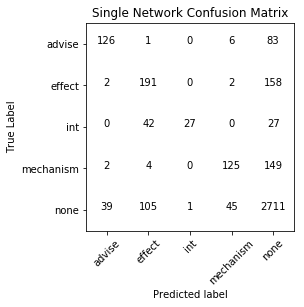

In [201]:
plot_confusion_matrix(true_labels, predictions, title = 'Single Network Confusion Matrix')

### Building the CNN Ensemble

We build a CNN Ensemble model based on the individual CNN described above. We use a Bagging approach. 

In [136]:
def build_cnn():
    unit_cnn = Sequential()
    unit_cnn.add(Embedding(input_dim = vocabulary_size,
                           output_dim = E,
                           embeddings_initializer = keras.initializers.RandomUniform(minval=-1.00, maxval=1.00, seed=None),
                           input_length = max_length))
    unit_cnn.add(Conv1D(filters = num_filters,
                        kernel_size = filter_size,
                        activation = 'relu',
                        kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)))
    unit_cnn.add(GlobalMaxPooling1D())
    unit_cnn.add(Dropout(rate = dropout_rate))
    unit_cnn.add(Dense(units = 5,
                       activation = 'softmax',
                       kernel_regularizer = keras.regularizers.l2(3.0)))

    unit_cnn.compile(optimizer = 'adam',
                     loss = 'categorical_crossentropy',
                     metrics = ['categorical_accuracy', f1])
    return unit_cnn

        
def sample_train_data(data, p = 0.85):
    '''samples a proportion (p) of the training data with replacement'''
    split_size = int(len(data)*p)
    indices = np.arange(len(data))
    choices = np.random.choice(indices, size = split_size, replace = True)
    train = data.loc[choices, : ]
    
    #convert to ids based on vocabulary and pad to max_length
    x_train_ids = vocabulary.texts_to_sequences(train['tokenized_sentences'])
    x_train = pad_sequences(x_train_ids, maxlen = max_length, padding = 'post', truncating = 'post')
    
    #tranform labels to one-hot vectors
    y_train = label_transformer.transform(train['ddi_type'])
    
    return (x_train, y_train)

def train_ensemble_cnns(models):
    histories = {}
    for i in range(len(models)):
        x_train, y_train = sample_train_data(train_data, p = 0.85)
        history = models[i].fit(x_train, 
             y_train, 
             batch_size = batch_size, 
             epochs = 20,
             validation_data = (x_test, y_test),
             callbacks = [metrics])
        print(f'training model {i+1} complete')
        print('----')
        histories[f'model_{i}'] = history
        models[i].save(f"F://keras_checkpoints//ensemble//model_{i+1}.hdf5")
    return histories

Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 76s 5ms/step - loss: 6.6820 - categorical_accuracy: 0.7433 - f1: 0.7433 - val_loss: 0.8587 - val_categorical_accuracy: 0.7561 - val_f1: 0.7561
validation f1-score: 0.7561102444097765


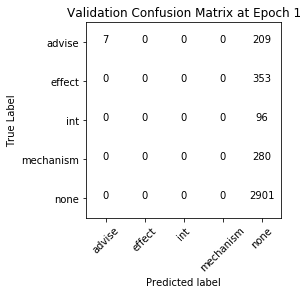

Epoch 2/20
15342/15342 [==============================] - 74s 5ms/step - loss: 0.7289 - categorical_accuracy: 0.7805 - f1: 0.7805 - val_loss: 0.7993 - val_categorical_accuracy: 0.7618 - val_f1: 0.7618
validation f1-score: 0.7618304732189287
Epoch 3/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.6818 - categorical_accuracy: 0.7893 - f1: 0.7893 - val_loss: 0.7844 - val_categorical_accuracy: 0.7774 - val_f1: 0.7774
validation f1-score: 0.7774310972438897
Epoch 4/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.6390 - categorical_accuracy: 0.8037 - f1: 0.8037 - val_loss: 0.7670 - val_categorical_accuracy: 0.7683 - val_f1: 0.7683
validation f1-score: 0.7683307332293292
Epoch 5/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.6058 - categorical_accuracy: 0.8144 - f1: 0.8144 - val_loss: 0.7232 - val_categorical_accuracy: 0.7824 - val_f1: 0.7824
validation f1-score: 0.782371294851794


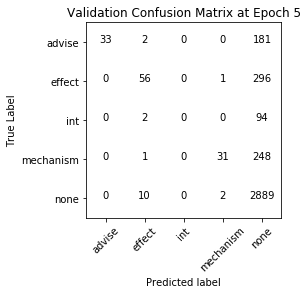

Epoch 6/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.5649 - categorical_accuracy: 0.8292 - f1: 0.8292 - val_loss: 0.7356 - val_categorical_accuracy: 0.7938 - val_f1: 0.7938
validation f1-score: 0.7938117524700988
Epoch 7/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.5355 - categorical_accuracy: 0.8404 - f1: 0.8404 - val_loss: 0.6861 - val_categorical_accuracy: 0.7912 - val_f1: 0.7912
validation f1-score: 0.7912116484659386
Epoch 8/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.5015 - categorical_accuracy: 0.8509 - f1: 0.8509 - val_loss: 0.6995 - val_categorical_accuracy: 0.7949 - val_f1: 0.7949
validation f1-score: 0.7948517940717629
Epoch 9/20
15342/15342 [==============================] - 71s 5ms/step - loss: 0.4697 - categorical_accuracy: 0.8610 - f1: 0.8610 - val_loss: 0.6675 - val_categorical_accuracy: 0.8003 - val_f1: 0.8003
validation f1-score: 0.8003120124804992
Epoch 10/20
15342/15342 [===========

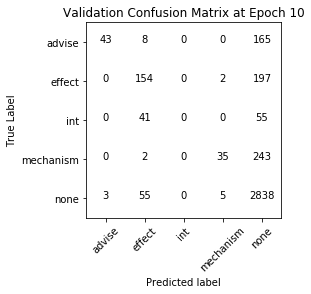

Epoch 11/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.4229 - categorical_accuracy: 0.8800 - f1: 0.8800 - val_loss: 0.6426 - val_categorical_accuracy: 0.8089 - val_f1: 0.8089
validation f1-score: 0.8088923556942277
Epoch 12/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.4021 - categorical_accuracy: 0.8858 - f1: 0.8858 - val_loss: 0.6186 - val_categorical_accuracy: 0.8276 - val_f1: 0.8276
validation f1-score: 0.827613104524181
Epoch 13/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.3866 - categorical_accuracy: 0.8951 - f1: 0.8951 - val_loss: 0.6257 - val_categorical_accuracy: 0.8196 - val_f1: 0.8196
validation f1-score: 0.8195527821112845
Epoch 14/20
15342/15342 [==============================] - 74s 5ms/step - loss: 0.3685 - categorical_accuracy: 0.9003 - f1: 0.9003 - val_loss: 0.6333 - val_categorical_accuracy: 0.8125 - val_f1: 0.8125
validation f1-score: 0.8125325013000521
Epoch 15/20
15342/15342 [========

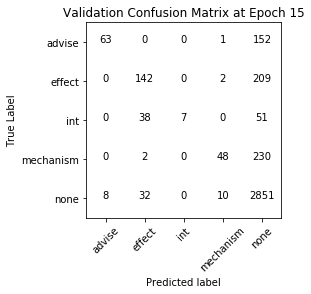

Epoch 16/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.3388 - categorical_accuracy: 0.9104 - f1: 0.9104 - val_loss: 0.6257 - val_categorical_accuracy: 0.8263 - val_f1: 0.8263
validation f1-score: 0.8263130525221009
Epoch 17/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.3270 - categorical_accuracy: 0.9149 - f1: 0.9149 - val_loss: 0.7059 - val_categorical_accuracy: 0.8131 - val_f1: 0.8131
validation f1-score: 0.8130525221008841
Epoch 18/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.3148 - categorical_accuracy: 0.9171 - f1: 0.9171 - val_loss: 0.6851 - val_categorical_accuracy: 0.7949 - val_f1: 0.7949
validation f1-score: 0.7948517940717629
Epoch 19/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.3007 - categorical_accuracy: 0.9203 - f1: 0.9203 - val_loss: 0.7318 - val_categorical_accuracy: 0.8089 - val_f1: 0.8089
validation f1-score: 0.8088923556942277
Epoch 20/20
15342/15342 [=======

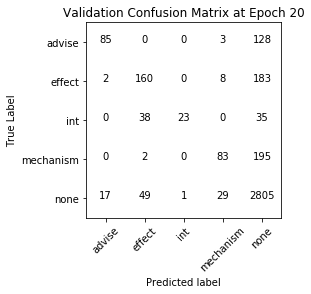

training model 1 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 73s 5ms/step - loss: 6.8861 - categorical_accuracy: 0.7484 - f1: 0.7484 - val_loss: 0.8647 - val_categorical_accuracy: 0.7543 - val_f1: 0.7543
validation f1-score: 0.7542901716068643


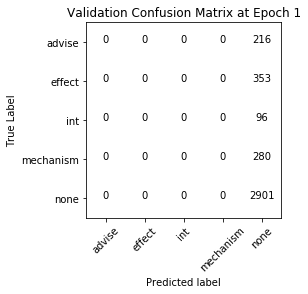

Epoch 2/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.7243 - categorical_accuracy: 0.7892 - f1: 0.7892 - val_loss: 0.7946 - val_categorical_accuracy: 0.7644 - val_f1: 0.7644
validation f1-score: 0.7644305772230889
Epoch 3/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.6712 - categorical_accuracy: 0.7994 - f1: 0.7994 - val_loss: 0.8247 - val_categorical_accuracy: 0.7579 - val_f1: 0.7579
validation f1-score: 0.7579303172126886
Epoch 4/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.6299 - categorical_accuracy: 0.8098 - f1: 0.8098 - val_loss: 0.7293 - val_categorical_accuracy: 0.7795 - val_f1: 0.7795
validation f1-score: 0.7795111804472179
Epoch 5/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.5894 - categorical_accuracy: 0.8186 - f1: 0.8186 - val_loss: 0.7008 - val_categorical_accuracy: 0.7907 - val_f1: 0.7907
validation f1-score: 0.7906916276651065


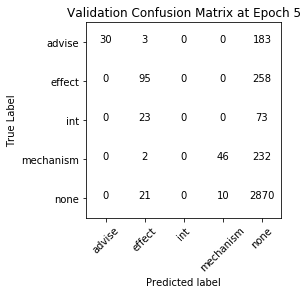

Epoch 6/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.5599 - categorical_accuracy: 0.8291 - f1: 0.8291 - val_loss: 0.6782 - val_categorical_accuracy: 0.7933 - val_f1: 0.7933
validation f1-score: 0.7932917316692668
Epoch 7/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.5229 - categorical_accuracy: 0.8415 - f1: 0.8415 - val_loss: 0.6808 - val_categorical_accuracy: 0.7925 - val_f1: 0.7925
validation f1-score: 0.7925117004680188
Epoch 8/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.4979 - categorical_accuracy: 0.8488 - f1: 0.8488 - val_loss: 0.6951 - val_categorical_accuracy: 0.7972 - val_f1: 0.7972
validation f1-score: 0.7971918876755069
Epoch 9/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.4685 - categorical_accuracy: 0.8571 - f1: 0.8571 - val_loss: 0.6503 - val_categorical_accuracy: 0.8029 - val_f1: 0.8029
validation f1-score: 0.8029121164846594
Epoch 10/20
15342/15342 [===========

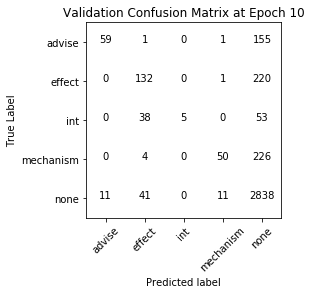

Epoch 11/20
15342/15342 [==============================] - 77s 5ms/step - loss: 0.4264 - categorical_accuracy: 0.8771 - f1: 0.8771 - val_loss: 0.6887 - val_categorical_accuracy: 0.8040 - val_f1: 0.8040
validation f1-score: 0.8039521580863235
Epoch 12/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.4048 - categorical_accuracy: 0.8852 - f1: 0.8852 - val_loss: 0.6461 - val_categorical_accuracy: 0.8110 - val_f1: 0.8110
validation f1-score: 0.8109724388975559
Epoch 13/20
15342/15342 [==============================] - 78s 5ms/step - loss: 0.3877 - categorical_accuracy: 0.8892 - f1: 0.8892 - val_loss: 0.6176 - val_categorical_accuracy: 0.8125 - val_f1: 0.8125
validation f1-score: 0.8125325013000521
Epoch 14/20
15342/15342 [==============================] - 78s 5ms/step - loss: 0.3682 - categorical_accuracy: 0.8962 - f1: 0.8962 - val_loss: 0.6137 - val_categorical_accuracy: 0.8224 - val_f1: 0.8224
validation f1-score: 0.8224128965158606
Epoch 15/20
15342/15342 [=======

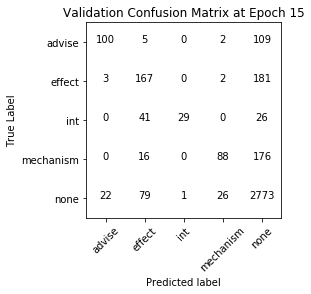

Epoch 16/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.3382 - categorical_accuracy: 0.9059 - f1: 0.9059 - val_loss: 0.6183 - val_categorical_accuracy: 0.8271 - val_f1: 0.8271
validation f1-score: 0.8270930837233489
Epoch 17/20
15342/15342 [==============================] - 81s 5ms/step - loss: 0.3361 - categorical_accuracy: 0.9076 - f1: 0.9076 - val_loss: 0.6179 - val_categorical_accuracy: 0.8190 - val_f1: 0.8190
validation f1-score: 0.8190327613104524
Epoch 18/20
15342/15342 [==============================] - 74s 5ms/step - loss: 0.3168 - categorical_accuracy: 0.9174 - f1: 0.9174 - val_loss: 0.6521 - val_categorical_accuracy: 0.8268 - val_f1: 0.8268
validation f1-score: 0.8268330733229329
Epoch 19/20
15342/15342 [==============================] - 76s 5ms/step - loss: 0.3021 - categorical_accuracy: 0.9203 - f1: 0.9203 - val_loss: 0.6568 - val_categorical_accuracy: 0.8196 - val_f1: 0.8196
validation f1-score: 0.8195527821112845
Epoch 20/20
15342/15342 [=======

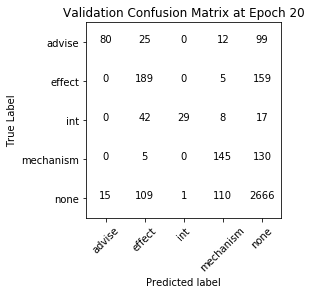

training model 2 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 78s 5ms/step - loss: 7.0151 - categorical_accuracy: 0.7373 - f1: 0.7373 - val_loss: 0.8582 - val_categorical_accuracy: 0.7543 - val_f1: 0.7543
validation f1-score: 0.7542901716068643


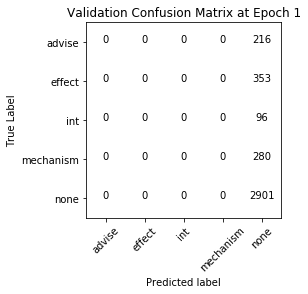

Epoch 2/20
15342/15342 [==============================] - 77s 5ms/step - loss: 0.7290 - categorical_accuracy: 0.7887 - f1: 0.7887 - val_loss: 0.7870 - val_categorical_accuracy: 0.7624 - val_f1: 0.7624
validation f1-score: 0.7623504940197607
Epoch 3/20
15342/15342 [==============================] - 74s 5ms/step - loss: 0.6867 - categorical_accuracy: 0.7949 - f1: 0.7949 - val_loss: 0.7976 - val_categorical_accuracy: 0.7582 - val_f1: 0.7582
validation f1-score: 0.7581903276131046
Epoch 4/20
15342/15342 [==============================] - 76s 5ms/step - loss: 0.6413 - categorical_accuracy: 0.8035 - f1: 0.8035 - val_loss: 0.7432 - val_categorical_accuracy: 0.7860 - val_f1: 0.7860
validation f1-score: 0.7860114404576183
Epoch 5/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.6002 - categorical_accuracy: 0.8172 - f1: 0.8172 - val_loss: 0.7350 - val_categorical_accuracy: 0.7767 - val_f1: 0.7767
validation f1-score: 0.7766510660426417


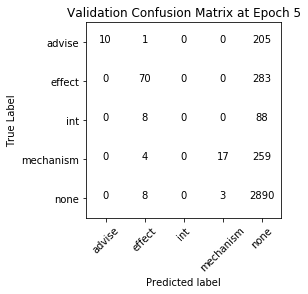

Epoch 6/20
15342/15342 [==============================] - 77s 5ms/step - loss: 0.5719 - categorical_accuracy: 0.8292 - f1: 0.8292 - val_loss: 0.6919 - val_categorical_accuracy: 0.7904 - val_f1: 0.7904
validation f1-score: 0.7904316172646906
Epoch 7/20
15342/15342 [==============================] - 75s 5ms/step - loss: 0.5285 - categorical_accuracy: 0.8406 - f1: 0.8406 - val_loss: 0.6808 - val_categorical_accuracy: 0.8027 - val_f1: 0.8027
validation f1-score: 0.8026521060842434
Epoch 8/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.5032 - categorical_accuracy: 0.8516 - f1: 0.8516 - val_loss: 0.6590 - val_categorical_accuracy: 0.7967 - val_f1: 0.7967
validation f1-score: 0.796671866874675
Epoch 9/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.4809 - categorical_accuracy: 0.8591 - f1: 0.8591 - val_loss: 0.7052 - val_categorical_accuracy: 0.7829 - val_f1: 0.7829
validation f1-score: 0.7828913156526262
Epoch 10/20
15342/15342 [============

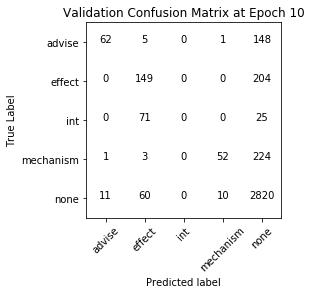

Epoch 11/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.4338 - categorical_accuracy: 0.8772 - f1: 0.8772 - val_loss: 0.6372 - val_categorical_accuracy: 0.8149 - val_f1: 0.8149
validation f1-score: 0.8148725949037962
Epoch 12/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.4089 - categorical_accuracy: 0.8849 - f1: 0.8849 - val_loss: 0.6194 - val_categorical_accuracy: 0.8183 - val_f1: 0.8183
validation f1-score: 0.8182527301092044
Epoch 13/20
15342/15342 [==============================] - 81s 5ms/step - loss: 0.3902 - categorical_accuracy: 0.8896 - f1: 0.8896 - val_loss: 0.6605 - val_categorical_accuracy: 0.8045 - val_f1: 0.8045
validation f1-score: 0.8044721788871555
Epoch 14/20
15342/15342 [==============================] - 78s 5ms/step - loss: 0.3713 - categorical_accuracy: 0.8967 - f1: 0.8967 - val_loss: 0.6140 - val_categorical_accuracy: 0.8193 - val_f1: 0.8193
validation f1-score: 0.8192927717108685
Epoch 15/20
15342/15342 [=======

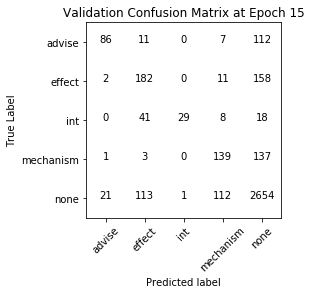

Epoch 16/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.3535 - categorical_accuracy: 0.9053 - f1: 0.9053 - val_loss: 0.6253 - val_categorical_accuracy: 0.8201 - val_f1: 0.8201
validation f1-score: 0.8200728029121165
Epoch 17/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.3335 - categorical_accuracy: 0.9118 - f1: 0.9118 - val_loss: 0.6134 - val_categorical_accuracy: 0.8209 - val_f1: 0.8209
validation f1-score: 0.8208528341133644
Epoch 18/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.3209 - categorical_accuracy: 0.9164 - f1: 0.9164 - val_loss: 0.6604 - val_categorical_accuracy: 0.8068 - val_f1: 0.8068
validation f1-score: 0.8068122724908996
Epoch 19/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.3153 - categorical_accuracy: 0.9170 - f1: 0.9170 - val_loss: 0.7075 - val_categorical_accuracy: 0.7863 - val_f1: 0.7863
validation f1-score: 0.7862714508580343
Epoch 20/20
15342/15342 [=======

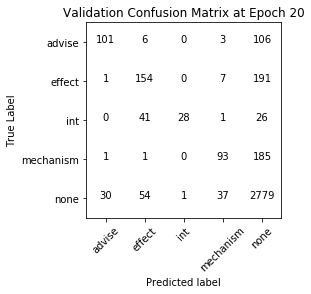

training model 3 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 79s 5ms/step - loss: 6.6881 - categorical_accuracy: 0.7519 - f1: 0.7519 - val_loss: 0.8628 - val_categorical_accuracy: 0.7543 - val_f1: 0.7543
validation f1-score: 0.7542901716068643


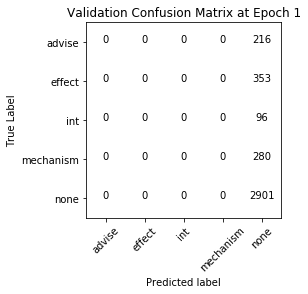

Epoch 2/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.7012 - categorical_accuracy: 0.7935 - f1: 0.7935 - val_loss: 0.7800 - val_categorical_accuracy: 0.7603 - val_f1: 0.7603
validation f1-score: 0.7602704108164327
Epoch 3/20
15342/15342 [==============================] - 77s 5ms/step - loss: 0.6581 - categorical_accuracy: 0.7999 - f1: 0.7999 - val_loss: 0.7517 - val_categorical_accuracy: 0.7668 - val_f1: 0.7668
validation f1-score: 0.766770670826833
Epoch 4/20
15342/15342 [==============================] - 79s 5ms/step - loss: 0.6187 - categorical_accuracy: 0.8124 - f1: 0.8124 - val_loss: 0.7362 - val_categorical_accuracy: 0.7878 - val_f1: 0.7878
validation f1-score: 0.7878315132605305
Epoch 5/20
15342/15342 [==============================] - 78s 5ms/step - loss: 0.5872 - categorical_accuracy: 0.8238 - f1: 0.8238 - val_loss: 0.7005 - val_categorical_accuracy: 0.7943 - val_f1: 0.7943
validation f1-score: 0.7943317732709309


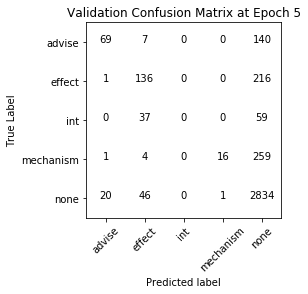

Epoch 6/20
15342/15342 [==============================] - 78s 5ms/step - loss: 0.5535 - categorical_accuracy: 0.8305 - f1: 0.8305 - val_loss: 0.7136 - val_categorical_accuracy: 0.7884 - val_f1: 0.7884
validation f1-score: 0.7883515340613625
Epoch 7/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.5161 - categorical_accuracy: 0.8409 - f1: 0.8409 - val_loss: 0.6689 - val_categorical_accuracy: 0.8006 - val_f1: 0.8006
validation f1-score: 0.8005720228809152
Epoch 8/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.5035 - categorical_accuracy: 0.8496 - f1: 0.8496 - val_loss: 0.6527 - val_categorical_accuracy: 0.8060 - val_f1: 0.8060
validation f1-score: 0.8060322412896516
Epoch 9/20
15342/15342 [==============================] - 81s 5ms/step - loss: 0.4692 - categorical_accuracy: 0.8592 - f1: 0.8592 - val_loss: 0.6428 - val_categorical_accuracy: 0.8032 - val_f1: 0.8032
validation f1-score: 0.8031721268850754
Epoch 10/20
15342/15342 [===========

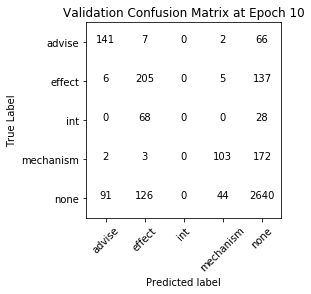

Epoch 11/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.4184 - categorical_accuracy: 0.8775 - f1: 0.8775 - val_loss: 0.6440 - val_categorical_accuracy: 0.8081 - val_f1: 0.8081
validation f1-score: 0.8081123244929798
Epoch 12/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.4004 - categorical_accuracy: 0.8855 - f1: 0.8855 - val_loss: 0.6468 - val_categorical_accuracy: 0.8063 - val_f1: 0.8063
validation f1-score: 0.8062922516900676
Epoch 13/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.3859 - categorical_accuracy: 0.8885 - f1: 0.8885 - val_loss: 0.6397 - val_categorical_accuracy: 0.8227 - val_f1: 0.8227
validation f1-score: 0.8226729069162767
Epoch 14/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.3668 - categorical_accuracy: 0.8999 - f1: 0.8999 - val_loss: 0.6158 - val_categorical_accuracy: 0.8190 - val_f1: 0.8190
validation f1-score: 0.8190327613104524
Epoch 15/20
15342/15342 [=======

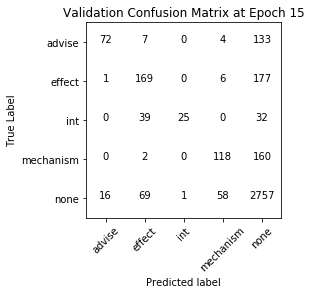

Epoch 16/20
15342/15342 [==============================] - 81s 5ms/step - loss: 0.3360 - categorical_accuracy: 0.9085 - f1: 0.9085 - val_loss: 0.6334 - val_categorical_accuracy: 0.8188 - val_f1: 0.8188
validation f1-score: 0.8187727509100364
Epoch 17/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.3291 - categorical_accuracy: 0.9130 - f1: 0.9130 - val_loss: 0.6570 - val_categorical_accuracy: 0.8185 - val_f1: 0.8185
validation f1-score: 0.8185127405096204
Epoch 18/20
15342/15342 [==============================] - 84s 5ms/step - loss: 0.3166 - categorical_accuracy: 0.9153 - f1: 0.9153 - val_loss: 0.6455 - val_categorical_accuracy: 0.8271 - val_f1: 0.8271
validation f1-score: 0.8270930837233489
Epoch 19/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.3049 - categorical_accuracy: 0.9198 - f1: 0.9198 - val_loss: 0.7089 - val_categorical_accuracy: 0.8133 - val_f1: 0.8133
validation f1-score: 0.8133125325013001
Epoch 20/20
15342/15342 [=======

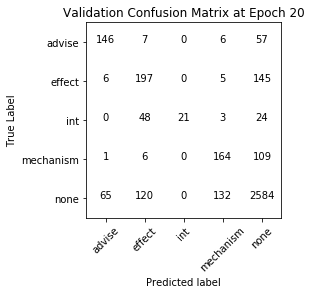

training model 4 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 83s 5ms/step - loss: 6.0773 - categorical_accuracy: 0.7579 - f1: 0.7579 - val_loss: 0.8486 - val_categorical_accuracy: 0.7543 - val_f1: 0.7543
validation f1-score: 0.7542901716068643


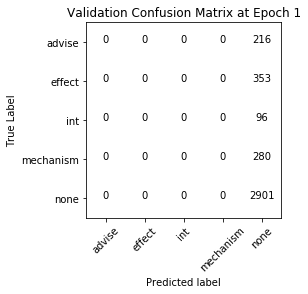

Epoch 2/20
15342/15342 [==============================] - 84s 5ms/step - loss: 0.7096 - categorical_accuracy: 0.7923 - f1: 0.7923 - val_loss: 0.8045 - val_categorical_accuracy: 0.7642 - val_f1: 0.7642
validation f1-score: 0.7641705668226729
Epoch 3/20
15342/15342 [==============================] - 84s 5ms/step - loss: 0.6626 - categorical_accuracy: 0.7998 - f1: 0.7998 - val_loss: 0.7853 - val_categorical_accuracy: 0.7629 - val_f1: 0.7629
validation f1-score: 0.7628705148205929
Epoch 4/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.6198 - categorical_accuracy: 0.8129 - f1: 0.8129 - val_loss: 0.7132 - val_categorical_accuracy: 0.7860 - val_f1: 0.7860
validation f1-score: 0.7860114404576183
Epoch 5/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.5894 - categorical_accuracy: 0.8193 - f1: 0.8193 - val_loss: 0.8301 - val_categorical_accuracy: 0.7691 - val_f1: 0.7691
validation f1-score: 0.7691107644305772


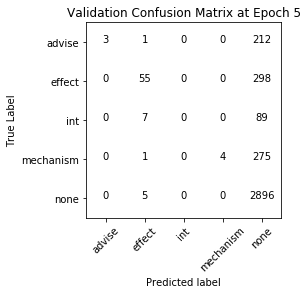

Epoch 6/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.5460 - categorical_accuracy: 0.8339 - f1: 0.8339 - val_loss: 0.7341 - val_categorical_accuracy: 0.7881 - val_f1: 0.7881
validation f1-score: 0.7880915236609466
Epoch 7/20
15342/15342 [==============================] - 85s 6ms/step - loss: 0.5184 - categorical_accuracy: 0.8436 - f1: 0.8436 - val_loss: 0.6785 - val_categorical_accuracy: 0.7980 - val_f1: 0.7980
validation f1-score: 0.7979719188767551
Epoch 8/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.4926 - categorical_accuracy: 0.8516 - f1: 0.8516 - val_loss: 0.6909 - val_categorical_accuracy: 0.7910 - val_f1: 0.7910
validation f1-score: 0.7909516380655226
Epoch 9/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.4519 - categorical_accuracy: 0.8663 - f1: 0.8663 - val_loss: 0.6858 - val_categorical_accuracy: 0.7959 - val_f1: 0.7959
validation f1-score: 0.7958918356734269
Epoch 10/20
15342/15342 [===========

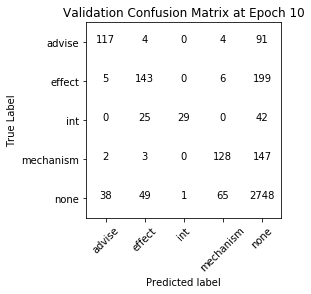

Epoch 11/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.4120 - categorical_accuracy: 0.8850 - f1: 0.8850 - val_loss: 0.6174 - val_categorical_accuracy: 0.8196 - val_f1: 0.8196
validation f1-score: 0.8195527821112845
Epoch 12/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.3890 - categorical_accuracy: 0.8915 - f1: 0.8915 - val_loss: 0.6746 - val_categorical_accuracy: 0.8076 - val_f1: 0.8076
validation f1-score: 0.8075923036921477
Epoch 13/20
15342/15342 [==============================] - 84s 5ms/step - loss: 0.3732 - categorical_accuracy: 0.8981 - f1: 0.8981 - val_loss: 0.6340 - val_categorical_accuracy: 0.8131 - val_f1: 0.8131
validation f1-score: 0.8130525221008841
Epoch 14/20
15342/15342 [==============================] - 81s 5ms/step - loss: 0.3615 - categorical_accuracy: 0.9006 - f1: 0.9006 - val_loss: 0.6650 - val_categorical_accuracy: 0.8151 - val_f1: 0.8151
validation f1-score: 0.8151326053042122
Epoch 15/20
15342/15342 [=======

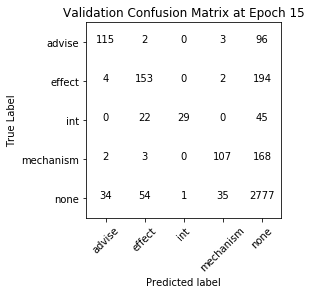

Epoch 16/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.3211 - categorical_accuracy: 0.9159 - f1: 0.9159 - val_loss: 0.7014 - val_categorical_accuracy: 0.8146 - val_f1: 0.8146
validation f1-score: 0.8146125845033801
Epoch 17/20
15342/15342 [==============================] - 82s 5ms/step - loss: 0.3182 - categorical_accuracy: 0.9166 - f1: 0.9166 - val_loss: 0.7949 - val_categorical_accuracy: 0.8066 - val_f1: 0.8066
validation f1-score: 0.8065522620904836
Epoch 18/20
15342/15342 [==============================] - 84s 5ms/step - loss: 0.3083 - categorical_accuracy: 0.9183 - f1: 0.9183 - val_loss: 0.6802 - val_categorical_accuracy: 0.7998 - val_f1: 0.7998
validation f1-score: 0.7997919916796672
Epoch 19/20
15342/15342 [==============================] - 80s 5ms/step - loss: 0.3010 - categorical_accuracy: 0.9226 - f1: 0.9226 - val_loss: 0.6969 - val_categorical_accuracy: 0.8201 - val_f1: 0.8201
validation f1-score: 0.8200728029121165
Epoch 20/20
15342/15342 [=======

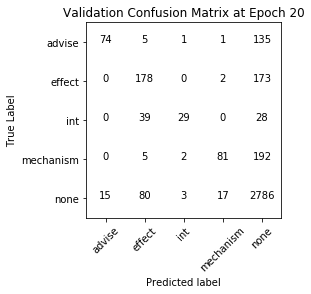

training model 5 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 87s 6ms/step - loss: 6.1240 - categorical_accuracy: 0.7481 - f1: 0.7481 - val_loss: 0.8497 - val_categorical_accuracy: 0.7551 - val_f1: 0.7551
validation f1-score: 0.7550702028081124


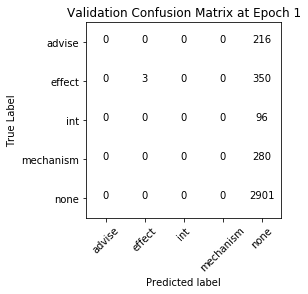

Epoch 2/20
15342/15342 [==============================] - 89s 6ms/step - loss: 0.7071 - categorical_accuracy: 0.7942 - f1: 0.7942 - val_loss: 0.8043 - val_categorical_accuracy: 0.7551 - val_f1: 0.7551
validation f1-score: 0.7550702028081124
Epoch 3/20
15342/15342 [==============================] - 86s 6ms/step - loss: 0.6623 - categorical_accuracy: 0.8017 - f1: 0.8017 - val_loss: 0.7722 - val_categorical_accuracy: 0.7681 - val_f1: 0.7681
validation f1-score: 0.7680707228289132
Epoch 4/20
15342/15342 [==============================] - 85s 6ms/step - loss: 0.6281 - categorical_accuracy: 0.8111 - f1: 0.8111 - val_loss: 0.7304 - val_categorical_accuracy: 0.7709 - val_f1: 0.7709
validation f1-score: 0.7709308372334893
Epoch 5/20
15342/15342 [==============================] - 85s 6ms/step - loss: 0.5776 - categorical_accuracy: 0.8235 - f1: 0.8235 - val_loss: 0.7230 - val_categorical_accuracy: 0.7886 - val_f1: 0.7886
validation f1-score: 0.7886115444617785


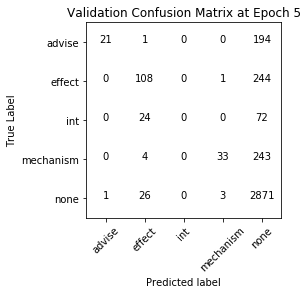

Epoch 6/20
15342/15342 [==============================] - 85s 6ms/step - loss: 0.5436 - categorical_accuracy: 0.8354 - f1: 0.8354 - val_loss: 0.7225 - val_categorical_accuracy: 0.7933 - val_f1: 0.7933
validation f1-score: 0.7932917316692668
Epoch 7/20
15342/15342 [==============================] - 88s 6ms/step - loss: 0.5121 - categorical_accuracy: 0.8490 - f1: 0.8490 - val_loss: 0.6631 - val_categorical_accuracy: 0.8016 - val_f1: 0.8016
validation f1-score: 0.8016120644825794
Epoch 8/20
15342/15342 [==============================] - 86s 6ms/step - loss: 0.4873 - categorical_accuracy: 0.8569 - f1: 0.8569 - val_loss: 0.6753 - val_categorical_accuracy: 0.7902 - val_f1: 0.7902
validation f1-score: 0.7901716068642746
Epoch 9/20
15342/15342 [==============================] - 87s 6ms/step - loss: 0.4588 - categorical_accuracy: 0.8698 - f1: 0.8698 - val_loss: 0.6486 - val_categorical_accuracy: 0.8055 - val_f1: 0.8055
validation f1-score: 0.8055122204888195
Epoch 10/20
15342/15342 [===========

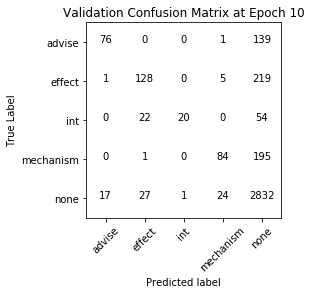

Epoch 11/20
15342/15342 [==============================] - 86s 6ms/step - loss: 0.4098 - categorical_accuracy: 0.8852 - f1: 0.8852 - val_loss: 0.6590 - val_categorical_accuracy: 0.8175 - val_f1: 0.8175
validation f1-score: 0.8174726989079563
Epoch 12/20
15342/15342 [==============================] - 86s 6ms/step - loss: 0.3916 - categorical_accuracy: 0.8916 - f1: 0.8916 - val_loss: 0.6251 - val_categorical_accuracy: 0.8149 - val_f1: 0.8149
validation f1-score: 0.8148725949037962
Epoch 13/20
15342/15342 [==============================] - 85s 6ms/step - loss: 0.3746 - categorical_accuracy: 0.8948 - f1: 0.8948 - val_loss: 0.7086 - val_categorical_accuracy: 0.7832 - val_f1: 0.7832
validation f1-score: 0.783151326053042
Epoch 14/20
15342/15342 [==============================] - 86s 6ms/step - loss: 0.3602 - categorical_accuracy: 0.9026 - f1: 0.9026 - val_loss: 0.6554 - val_categorical_accuracy: 0.8060 - val_f1: 0.8060
validation f1-score: 0.8060322412896516
Epoch 15/20
15342/15342 [========

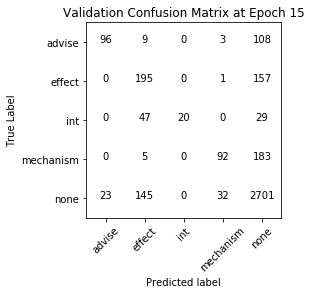

Epoch 16/20
15342/15342 [==============================] - 84s 5ms/step - loss: 0.3277 - categorical_accuracy: 0.9149 - f1: 0.9149 - val_loss: 0.7093 - val_categorical_accuracy: 0.7860 - val_f1: 0.7860
validation f1-score: 0.7860114404576183
Epoch 17/20
15342/15342 [==============================] - 87s 6ms/step - loss: 0.3183 - categorical_accuracy: 0.9164 - f1: 0.9164 - val_loss: 0.6519 - val_categorical_accuracy: 0.8162 - val_f1: 0.8162
validation f1-score: 0.8161726469058762
Epoch 18/20
15342/15342 [==============================] - 85s 6ms/step - loss: 0.3098 - categorical_accuracy: 0.9180 - f1: 0.9180 - val_loss: 0.6617 - val_categorical_accuracy: 0.8138 - val_f1: 0.8138
validation f1-score: 0.8138325533021322
Epoch 19/20
15342/15342 [==============================] - 86s 6ms/step - loss: 0.3016 - categorical_accuracy: 0.9211 - f1: 0.9211 - val_loss: 0.6636 - val_categorical_accuracy: 0.8198 - val_f1: 0.8198
validation f1-score: 0.8198127925117006
Epoch 20/20
15342/15342 [=======

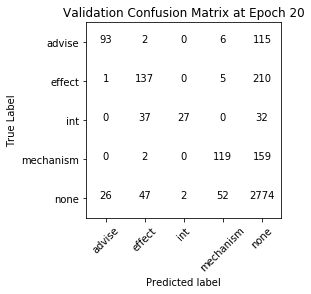

training model 6 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 90s 6ms/step - loss: 6.3896 - categorical_accuracy: 0.7453 - f1: 0.7453 - val_loss: 0.8956 - val_categorical_accuracy: 0.7543 - val_f1: 0.7543
validation f1-score: 0.7542901716068643


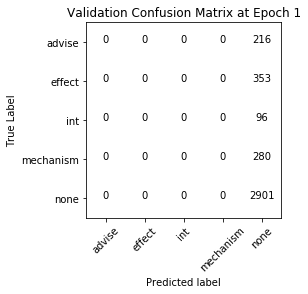

Epoch 2/20
15342/15342 [==============================] - 90s 6ms/step - loss: 0.7128 - categorical_accuracy: 0.7899 - f1: 0.7899 - val_loss: 0.8017 - val_categorical_accuracy: 0.7668 - val_f1: 0.7668
validation f1-score: 0.766770670826833
Epoch 3/20
15342/15342 [==============================] - 91s 6ms/step - loss: 0.6619 - categorical_accuracy: 0.7966 - f1: 0.7966 - val_loss: 0.7469 - val_categorical_accuracy: 0.7743 - val_f1: 0.7743
validation f1-score: 0.7743109724388976
Epoch 4/20
15342/15342 [==============================] - 92s 6ms/step - loss: 0.6238 - categorical_accuracy: 0.8100 - f1: 0.8100 - val_loss: 0.7487 - val_categorical_accuracy: 0.7715 - val_f1: 0.7715
validation f1-score: 0.7714508580343212
Epoch 5/20
15342/15342 [==============================] - 96s 6ms/step - loss: 0.5866 - categorical_accuracy: 0.8189 - f1: 0.8189 - val_loss: 0.6932 - val_categorical_accuracy: 0.7990 - val_f1: 0.7990
validation f1-score: 0.7990119604784192


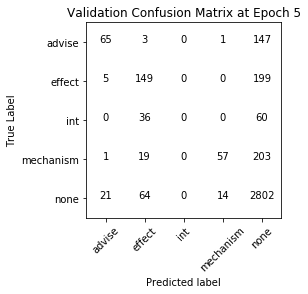

Epoch 6/20
15342/15342 [==============================] - 92s 6ms/step - loss: 0.5502 - categorical_accuracy: 0.8345 - f1: 0.8345 - val_loss: 0.7030 - val_categorical_accuracy: 0.7894 - val_f1: 0.7894
validation f1-score: 0.7893915756630265
Epoch 7/20
15342/15342 [==============================] - 95s 6ms/step - loss: 0.5211 - categorical_accuracy: 0.8448 - f1: 0.8448 - val_loss: 0.6669 - val_categorical_accuracy: 0.7980 - val_f1: 0.7980
validation f1-score: 0.7979719188767551
Epoch 8/20
15342/15342 [==============================] - 95s 6ms/step - loss: 0.4849 - categorical_accuracy: 0.8548 - f1: 0.8548 - val_loss: 0.6429 - val_categorical_accuracy: 0.8118 - val_f1: 0.8118
validation f1-score: 0.8117524700988039
Epoch 9/20
15342/15342 [==============================] - 93s 6ms/step - loss: 0.4556 - categorical_accuracy: 0.8666 - f1: 0.8666 - val_loss: 0.6515 - val_categorical_accuracy: 0.8102 - val_f1: 0.8102
validation f1-score: 0.8101924076963077
Epoch 10/20
15342/15342 [===========

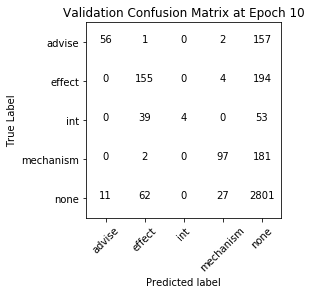

Epoch 11/20
15342/15342 [==============================] - 93s 6ms/step - loss: 0.4174 - categorical_accuracy: 0.8803 - f1: 0.8803 - val_loss: 0.6385 - val_categorical_accuracy: 0.8190 - val_f1: 0.8190
validation f1-score: 0.8190327613104524
Epoch 12/20
15342/15342 [==============================] - 102s 7ms/step - loss: 0.3978 - categorical_accuracy: 0.8885 - f1: 0.8885 - val_loss: 0.6354 - val_categorical_accuracy: 0.8175 - val_f1: 0.8175
validation f1-score: 0.8174726989079563
Epoch 13/20
15342/15342 [==============================] - 104s 7ms/step - loss: 0.3768 - categorical_accuracy: 0.8954 - f1: 0.8954 - val_loss: 0.6375 - val_categorical_accuracy: 0.8193 - val_f1: 0.8193
validation f1-score: 0.8192927717108685
Epoch 14/20
15342/15342 [==============================] - 103s 7ms/step - loss: 0.3567 - categorical_accuracy: 0.9016 - f1: 0.9016 - val_loss: 0.6339 - val_categorical_accuracy: 0.8055 - val_f1: 0.8055
validation f1-score: 0.8055122204888195
Epoch 15/20
15342/15342 [====

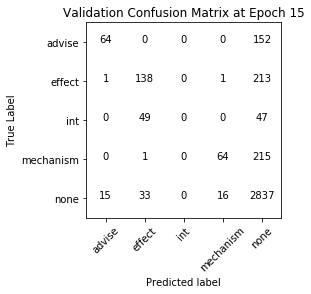

Epoch 16/20
15342/15342 [==============================] - 103s 7ms/step - loss: 0.3264 - categorical_accuracy: 0.9147 - f1: 0.9147 - val_loss: 0.6596 - val_categorical_accuracy: 0.8185 - val_f1: 0.8185
validation f1-score: 0.8185127405096204
Epoch 17/20
15342/15342 [==============================] - 101s 7ms/step - loss: 0.3200 - categorical_accuracy: 0.9159 - f1: 0.9159 - val_loss: 0.6259 - val_categorical_accuracy: 0.8131 - val_f1: 0.8131
validation f1-score: 0.8130525221008841
Epoch 18/20
15342/15342 [==============================] - 100s 7ms/step - loss: 0.3106 - categorical_accuracy: 0.9184 - f1: 0.9184 - val_loss: 0.6268 - val_categorical_accuracy: 0.8279 - val_f1: 0.8279
validation f1-score: 0.827873114924597
Epoch 19/20
15342/15342 [==============================] - 106s 7ms/step - loss: 0.2973 - categorical_accuracy: 0.9237 - f1: 0.9237 - val_loss: 0.6330 - val_categorical_accuracy: 0.8279 - val_f1: 0.8279
validation f1-score: 0.827873114924597
Epoch 20/20
15342/15342 [=====

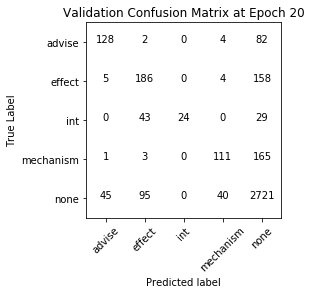

training model 7 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 102s 7ms/step - loss: 7.1828 - categorical_accuracy: 0.7389 - f1: 0.7389 - val_loss: 0.8728 - val_categorical_accuracy: 0.7577 - val_f1: 0.7577
validation f1-score: 0.7576703068122725


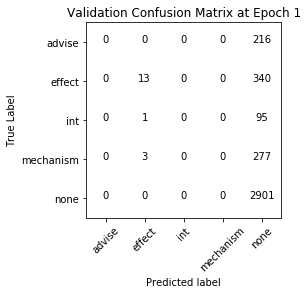

Epoch 2/20
15342/15342 [==============================] - 103s 7ms/step - loss: 0.7188 - categorical_accuracy: 0.7906 - f1: 0.7906 - val_loss: 0.8016 - val_categorical_accuracy: 0.7748 - val_f1: 0.7748
validation f1-score: 0.7748309932397295
Epoch 3/20
15342/15342 [==============================] - 101s 7ms/step - loss: 0.6765 - categorical_accuracy: 0.7968 - f1: 0.7968 - val_loss: 0.7569 - val_categorical_accuracy: 0.7665 - val_f1: 0.7665
validation f1-score: 0.766510660426417
Epoch 4/20
15342/15342 [==============================] - 102s 7ms/step - loss: 0.6341 - categorical_accuracy: 0.8092 - f1: 0.8092 - val_loss: 0.7565 - val_categorical_accuracy: 0.7811 - val_f1: 0.7811
validation f1-score: 0.7810712428497141
Epoch 5/20
15342/15342 [==============================] - 101s 7ms/step - loss: 0.5987 - categorical_accuracy: 0.8195 - f1: 0.8195 - val_loss: 0.7237 - val_categorical_accuracy: 0.7907 - val_f1: 0.7907
validation f1-score: 0.7906916276651065


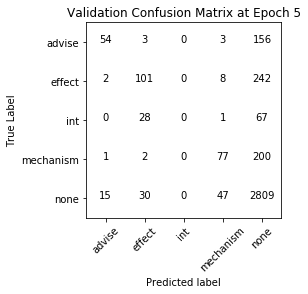

Epoch 6/20
15342/15342 [==============================] - 102s 7ms/step - loss: 0.5611 - categorical_accuracy: 0.8291 - f1: 0.8291 - val_loss: 0.6866 - val_categorical_accuracy: 0.7951 - val_f1: 0.7951
validation f1-score: 0.7951118044721789
Epoch 7/20
15342/15342 [==============================] - 104s 7ms/step - loss: 0.5265 - categorical_accuracy: 0.8427 - f1: 0.8427 - val_loss: 0.6794 - val_categorical_accuracy: 0.7873 - val_f1: 0.7873
validation f1-score: 0.7873114924596983
Epoch 8/20
15342/15342 [==============================] - 103s 7ms/step - loss: 0.4959 - categorical_accuracy: 0.8547 - f1: 0.8547 - val_loss: 0.6657 - val_categorical_accuracy: 0.8068 - val_f1: 0.8068
validation f1-score: 0.8068122724908996
Epoch 9/20
15342/15342 [==============================] - 94s 6ms/step - loss: 0.4710 - categorical_accuracy: 0.8636 - f1: 0.8636 - val_loss: 0.6338 - val_categorical_accuracy: 0.8073 - val_f1: 0.8073
validation f1-score: 0.8073322932917316
Epoch 10/20
15342/15342 [========

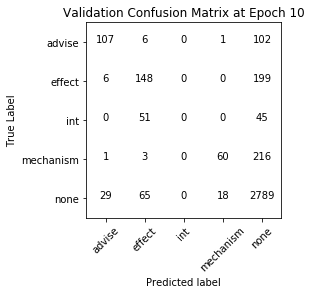

Epoch 11/20
15342/15342 [==============================] - 91s 6ms/step - loss: 0.4287 - categorical_accuracy: 0.8741 - f1: 0.8741 - val_loss: 0.6411 - val_categorical_accuracy: 0.8060 - val_f1: 0.8060
validation f1-score: 0.8060322412896516
Epoch 12/20
15342/15342 [==============================] - 90s 6ms/step - loss: 0.4019 - categorical_accuracy: 0.8885 - f1: 0.8885 - val_loss: 0.6272 - val_categorical_accuracy: 0.8115 - val_f1: 0.8115
validation f1-score: 0.8114924596983879
Epoch 13/20
15342/15342 [==============================] - 90s 6ms/step - loss: 0.3875 - categorical_accuracy: 0.8936 - f1: 0.8936 - val_loss: 0.6293 - val_categorical_accuracy: 0.8149 - val_f1: 0.8149
validation f1-score: 0.8148725949037962
Epoch 14/20
15342/15342 [==============================] - 91s 6ms/step - loss: 0.3651 - categorical_accuracy: 0.9022 - f1: 0.9022 - val_loss: 0.6395 - val_categorical_accuracy: 0.8133 - val_f1: 0.8133
validation f1-score: 0.8133125325013001
Epoch 15/20
15342/15342 [=======

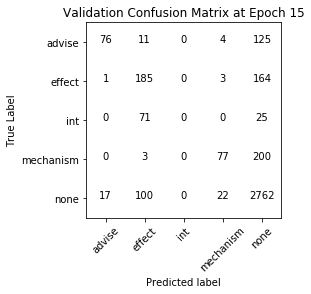

Epoch 16/20
15342/15342 [==============================] - 91s 6ms/step - loss: 0.3398 - categorical_accuracy: 0.9099 - f1: 0.9099 - val_loss: 0.6646 - val_categorical_accuracy: 0.8224 - val_f1: 0.8224
validation f1-score: 0.8224128965158606
Epoch 17/20
15342/15342 [==============================] - 92s 6ms/step - loss: 0.3286 - categorical_accuracy: 0.9132 - f1: 0.9132 - val_loss: 0.6425 - val_categorical_accuracy: 0.8042 - val_f1: 0.8042
validation f1-score: 0.8042121684867395
Epoch 18/20
15342/15342 [==============================] - 83s 5ms/step - loss: 0.3220 - categorical_accuracy: 0.9149 - f1: 0.9149 - val_loss: 0.6640 - val_categorical_accuracy: 0.8175 - val_f1: 0.8175
validation f1-score: 0.8174726989079563
Epoch 19/20
15342/15342 [==============================] - 71s 5ms/step - loss: 0.3115 - categorical_accuracy: 0.9212 - f1: 0.9212 - val_loss: 0.6264 - val_categorical_accuracy: 0.8216 - val_f1: 0.8216
validation f1-score: 0.8216328653146124
Epoch 20/20
15342/15342 [=======

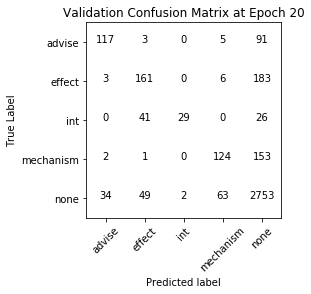

training model 8 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 71s 5ms/step - loss: 5.9340 - categorical_accuracy: 0.7479 - f1: 0.7479 - val_loss: 0.8464 - val_categorical_accuracy: 0.7546 - val_f1: 0.7546
validation f1-score: 0.7545501820072803


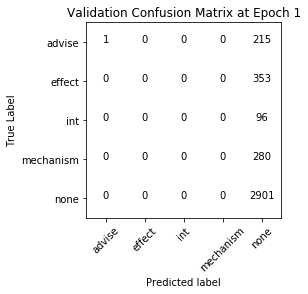

Epoch 2/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.7091 - categorical_accuracy: 0.7879 - f1: 0.7879 - val_loss: 0.7936 - val_categorical_accuracy: 0.7686 - val_f1: 0.7686
validation f1-score: 0.7685907436297452
Epoch 3/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.6637 - categorical_accuracy: 0.7964 - f1: 0.7964 - val_loss: 0.7692 - val_categorical_accuracy: 0.7813 - val_f1: 0.7813
validation f1-score: 0.78133125325013
Epoch 4/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.6283 - categorical_accuracy: 0.8077 - f1: 0.8077 - val_loss: 0.7398 - val_categorical_accuracy: 0.7696 - val_f1: 0.7696
validation f1-score: 0.7696307852314093
Epoch 5/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.5837 - categorical_accuracy: 0.8198 - f1: 0.8198 - val_loss: 0.7078 - val_categorical_accuracy: 0.7972 - val_f1: 0.7972
validation f1-score: 0.7971918876755069


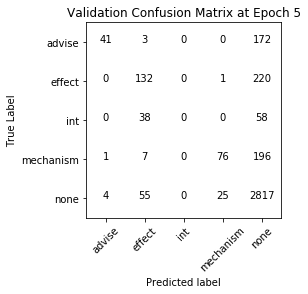

Epoch 6/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.5535 - categorical_accuracy: 0.8326 - f1: 0.8326 - val_loss: 0.6764 - val_categorical_accuracy: 0.7946 - val_f1: 0.7946
validation f1-score: 0.7945917836713469
Epoch 7/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.5204 - categorical_accuracy: 0.8431 - f1: 0.8431 - val_loss: 0.7006 - val_categorical_accuracy: 0.7915 - val_f1: 0.7915
validation f1-score: 0.7914716588663545
Epoch 8/20
15342/15342 [==============================] - 71s 5ms/step - loss: 0.4920 - categorical_accuracy: 0.8548 - f1: 0.8548 - val_loss: 0.6608 - val_categorical_accuracy: 0.8040 - val_f1: 0.8040
validation f1-score: 0.8039521580863235
Epoch 9/20
15342/15342 [==============================] - 71s 5ms/step - loss: 0.4618 - categorical_accuracy: 0.8659 - f1: 0.8659 - val_loss: 0.6325 - val_categorical_accuracy: 0.8214 - val_f1: 0.8214
validation f1-score: 0.8213728549141965
Epoch 10/20
15342/15342 [===========

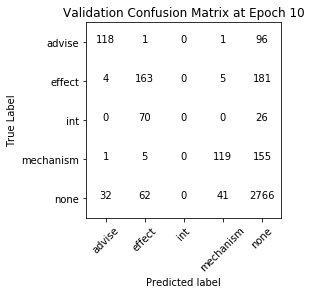

Epoch 11/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.4177 - categorical_accuracy: 0.8829 - f1: 0.8829 - val_loss: 0.6313 - val_categorical_accuracy: 0.8133 - val_f1: 0.8133
validation f1-score: 0.8133125325013001
Epoch 12/20
15342/15342 [==============================] - 71s 5ms/step - loss: 0.3919 - categorical_accuracy: 0.8953 - f1: 0.8953 - val_loss: 0.6331 - val_categorical_accuracy: 0.8159 - val_f1: 0.8159
validation f1-score: 0.8159126365054602
Epoch 13/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.3732 - categorical_accuracy: 0.8983 - f1: 0.8983 - val_loss: 0.6846 - val_categorical_accuracy: 0.8154 - val_f1: 0.8154
validation f1-score: 0.8153926157046283
Epoch 14/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.3537 - categorical_accuracy: 0.9087 - f1: 0.9087 - val_loss: 0.6157 - val_categorical_accuracy: 0.8203 - val_f1: 0.8203
validation f1-score: 0.8203328133125325
Epoch 15/20
15342/15342 [=======

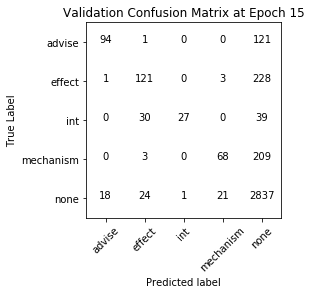

Epoch 16/20
15342/15342 [==============================] - 73s 5ms/step - loss: 0.3290 - categorical_accuracy: 0.9132 - f1: 0.9132 - val_loss: 0.6531 - val_categorical_accuracy: 0.8177 - val_f1: 0.8177
validation f1-score: 0.8177327093083725
Epoch 17/20
15342/15342 [==============================] - 69s 4ms/step - loss: 0.3169 - categorical_accuracy: 0.9174 - f1: 0.9174 - val_loss: 0.6354 - val_categorical_accuracy: 0.8224 - val_f1: 0.8224
validation f1-score: 0.8224128965158606
Epoch 18/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.3058 - categorical_accuracy: 0.9227 - f1: 0.9227 - val_loss: 0.7059 - val_categorical_accuracy: 0.8172 - val_f1: 0.8172
validation f1-score: 0.8172126885075403
Epoch 19/20
15342/15342 [==============================] - 67s 4ms/step - loss: 0.3032 - categorical_accuracy: 0.9202 - f1: 0.9202 - val_loss: 0.6921 - val_categorical_accuracy: 0.8183 - val_f1: 0.8183
validation f1-score: 0.8182527301092044
Epoch 20/20
15342/15342 [=======

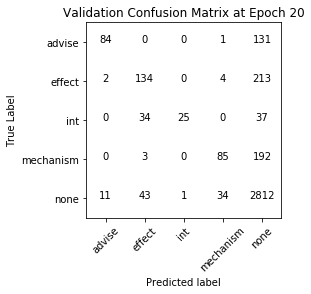

training model 9 complete
----
Train on 15342 samples, validate on 3846 samples
Epoch 1/20
15342/15342 [==============================] - 64s 4ms/step - loss: 6.8253 - categorical_accuracy: 0.7416 - f1: 0.7416 - val_loss: 0.8654 - val_categorical_accuracy: 0.7543 - val_f1: 0.7543
validation f1-score: 0.7542901716068643


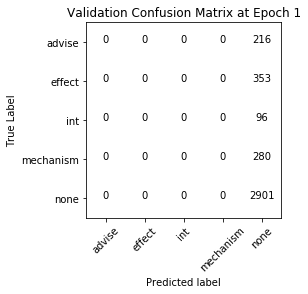

Epoch 2/20
15342/15342 [==============================] - 65s 4ms/step - loss: 0.7189 - categorical_accuracy: 0.7878 - f1: 0.7878 - val_loss: 0.7994 - val_categorical_accuracy: 0.7585 - val_f1: 0.7585
validation f1-score: 0.7584503380135205
Epoch 3/20
15342/15342 [==============================] - 64s 4ms/step - loss: 0.6773 - categorical_accuracy: 0.7970 - f1: 0.7970 - val_loss: 0.7785 - val_categorical_accuracy: 0.7624 - val_f1: 0.7624
validation f1-score: 0.7623504940197607
Epoch 4/20
15342/15342 [==============================] - 64s 4ms/step - loss: 0.6354 - categorical_accuracy: 0.8036 - f1: 0.8036 - val_loss: 0.7480 - val_categorical_accuracy: 0.7806 - val_f1: 0.7806
validation f1-score: 0.780551222048882
Epoch 5/20
15342/15342 [==============================] - 64s 4ms/step - loss: 0.6009 - categorical_accuracy: 0.8151 - f1: 0.8151 - val_loss: 0.7090 - val_categorical_accuracy: 0.7824 - val_f1: 0.7824
validation f1-score: 0.782371294851794


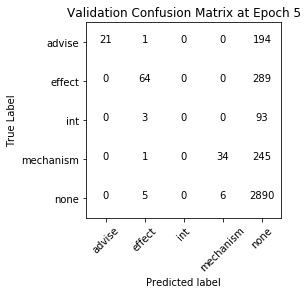

Epoch 6/20
15342/15342 [==============================] - 63s 4ms/step - loss: 0.5718 - categorical_accuracy: 0.8249 - f1: 0.8249 - val_loss: 0.7007 - val_categorical_accuracy: 0.7993 - val_f1: 0.7993
validation f1-score: 0.7992719708788352
Epoch 7/20
15342/15342 [==============================] - 64s 4ms/step - loss: 0.5346 - categorical_accuracy: 0.8369 - f1: 0.8369 - val_loss: 0.6891 - val_categorical_accuracy: 0.8066 - val_f1: 0.8066
validation f1-score: 0.8065522620904836
Epoch 8/20
15342/15342 [==============================] - 64s 4ms/step - loss: 0.5087 - categorical_accuracy: 0.8449 - f1: 0.8449 - val_loss: 0.6659 - val_categorical_accuracy: 0.8019 - val_f1: 0.8019
validation f1-score: 0.8018720748829953
Epoch 9/20
15342/15342 [==============================] - 65s 4ms/step - loss: 0.4906 - categorical_accuracy: 0.8505 - f1: 0.8505 - val_loss: 0.6423 - val_categorical_accuracy: 0.8105 - val_f1: 0.8105
validation f1-score: 0.8104524180967239
Epoch 10/20
15342/15342 [===========

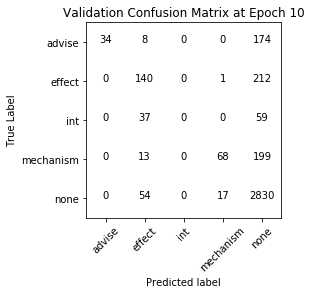

Epoch 11/20
15342/15342 [==============================] - 65s 4ms/step - loss: 0.4387 - categorical_accuracy: 0.8707 - f1: 0.8707 - val_loss: 0.6254 - val_categorical_accuracy: 0.8216 - val_f1: 0.8216
validation f1-score: 0.8216328653146124
Epoch 12/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.4238 - categorical_accuracy: 0.8754 - f1: 0.8754 - val_loss: 0.6318 - val_categorical_accuracy: 0.8136 - val_f1: 0.8136
validation f1-score: 0.8135725429017161
Epoch 13/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.4010 - categorical_accuracy: 0.8843 - f1: 0.8843 - val_loss: 0.6496 - val_categorical_accuracy: 0.8172 - val_f1: 0.8172
validation f1-score: 0.8172126885075403
Epoch 14/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.3854 - categorical_accuracy: 0.8911 - f1: 0.8911 - val_loss: 0.6455 - val_categorical_accuracy: 0.8154 - val_f1: 0.8154
validation f1-score: 0.8153926157046283
Epoch 15/20
15342/15342 [=======

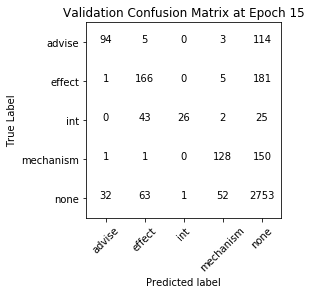

Epoch 16/20
15342/15342 [==============================] - 72s 5ms/step - loss: 0.3566 - categorical_accuracy: 0.9025 - f1: 0.9025 - val_loss: 0.6645 - val_categorical_accuracy: 0.8162 - val_f1: 0.8162
validation f1-score: 0.8161726469058762
Epoch 17/20
15342/15342 [==============================] - 69s 4ms/step - loss: 0.3391 - categorical_accuracy: 0.9063 - f1: 0.9063 - val_loss: 0.6545 - val_categorical_accuracy: 0.8211 - val_f1: 0.8211
validation f1-score: 0.8211128445137805
Epoch 18/20
15342/15342 [==============================] - 70s 5ms/step - loss: 0.3261 - categorical_accuracy: 0.9132 - f1: 0.9132 - val_loss: 0.6543 - val_categorical_accuracy: 0.8216 - val_f1: 0.8216
validation f1-score: 0.8216328653146124
Epoch 19/20
15342/15342 [==============================] - 71s 5ms/step - loss: 0.3221 - categorical_accuracy: 0.9140 - f1: 0.9140 - val_loss: 0.6492 - val_categorical_accuracy: 0.8040 - val_f1: 0.8040
validation f1-score: 0.8039521580863235
Epoch 20/20
15342/15342 [=======

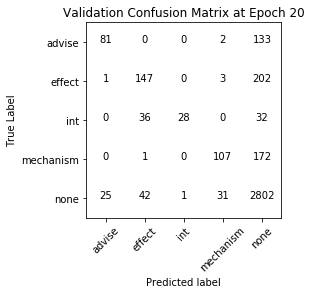

training model 10 complete
----


TypeError: can't pickle _thread.lock objects

In [137]:
model_list = []
for i in range(10):
    m = build_cnn()
    model_list.append(m)

ensemble_histories = train_ensemble_cnns(model_list)
write_to_pickle(ensemble_histories, 'ensemble_histories.pickle')

Check individual model performance on test set

In [151]:
i = 1
score_list = []
for model in model_list:
    predict = to_one_hot(model.predict(x_test, batch_size = 50))
    score = f1_score(to_labels(y_test), to_labels(predict), average = 'micro')
    score_list.append(score)
    print(f'F1-score for model {i} is {score}')
    i += 1

F1-score for model 1 is 0.8205928237129485
F1-score for model 2 is 0.8083723348933958
F1-score for model 3 is 0.8203328133125325
F1-score for model 4 is 0.8091523660946438
F1-score for model 5 is 0.8185127405096204
F1-score for model 6 is 0.8190327613104524
F1-score for model 7 is 0.8242329693187728
F1-score for model 8 is 0.827873114924597
F1-score for model 9 is 0.8164326573062923
F1-score for model 10 is 0.8229329173166927


Aggregate models for overall ensemble prediction by summing predicted probabilities for each model and taking the argmax

In [155]:
overall_predictions = []
for model in model_list:
    overall_predictions.append(model.predict(x_test, batch_size = 50))

aggregate_predictions = sum(overall_predictions)

In [156]:
ensemble_predictions = to_labels(to_one_hot(aggregate_predictions))

In [224]:
print(f1_score(to_labels(y_test), ensemble_predictions, average = 'micro'))
print('---')
print(classification_report(to_labels(y_test), ensemble_predictions))

0.8309932397295892
---
             precision    recall  f1-score   support

     advise       0.80      0.47      0.59       216
     effect       0.63      0.46      0.53       353
        int       0.96      0.28      0.44        96
  mechanism       0.73      0.40      0.52       280
       none       0.85      0.96      0.90      2901

avg / total       0.82      0.83      0.81      3846



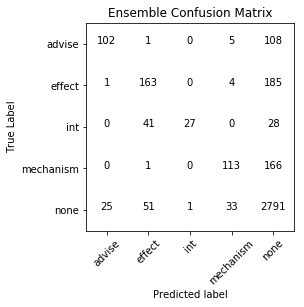

In [171]:
plot_confusion_matrix(to_labels(y_test), ensemble_predictions, title = 'Ensemble Confusion Matrix')

## Error Analysis

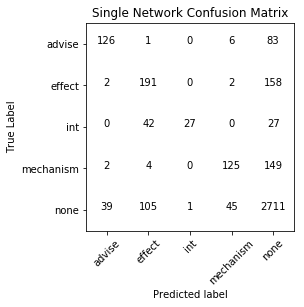

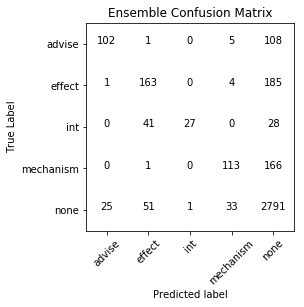

In [178]:
plot_confusion_matrix(true_labels, predictions, title = 'Single Network Confusion Matrix')
plot_confusion_matrix(to_labels(y_test), ensemble_predictions, title = 'Ensemble Confusion Matrix')

In [202]:
train_data['ddi_type'].value_counts()

none         14155
effect        1653
mechanism     1276
advise         781
int            185
Name: ddi_type, dtype: int64

From the confusion matrix, it is clear that the class imbalance in the trainig dataset is one of the major factors impacting performance on the test set. Even after negative instance filtering, the 'none' class still makes up around 78% of the training data. Another large source of confusion is the misclassification of 'int' labels as 'effect'. We examine some of these errors here.

First, we look at some examples of the misclassification where true 'int' labels are misclassified as 'effect'.

In [223]:
test_with_predictions = test_data
test_with_predictions['predicted_label'] = predictions
test_with_predictions['predicted_label_ensemble'] = ensemble_predictions
error_eff = test_with_predictions[(test_with_predictions['ddi_type'] == 'int') & (test_with_predictions['predicted_label'] == 'effect')]
for i in [1504, 2415, 2761]:
    print(error_eff.loc[i]['tokenized_sentences'])
    print(" ")

other drugs which may enhance the neuromuscular blocking action of drug1 such as drug0 include certain drug2 ( e.g. , drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , and drug0 ) , drug0 salts , drug0 , local drug0 , drug0 , and drug0 .
 
concomitant use of drug1 with drug2 may result in an adverse drug interaction .
 
use with drug0 : because of their mechanism of action , drug1 have the potential to interfere with the activity of drug2 .
 


Next, we look at some examples of sentences that are associated with the 'effect' label

In [218]:
for i in [4, 65, 66]:
    print(test_with_predictions[test_with_predictions['ddi_type'] == 'effect'].loc[i]['tokenized_sentences'])
    print(" ")

the incremental ldl-c reduction due to adding drug1 to drug2 may be reduced by this interaction .
 
these are described in greater detail below : oral drug0 , drug0-type drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , drug0 , short-acting drug0 , oral drug0 : clinically significant hypoglycemia may be precipitated by the use of drug1 with oral drug2 ;
 
one fatality has been reported from hypoglycemia in association with combined drug1 and drug2 use .
 


From the example sentences, one possible reason that the model misclassifies 'int' labels as 'effect' is that sentences in each of the categories are extremely similar with subtle differences. Drug interactions described by the 'effect' label clearly state the consequences of what happens when drug1 is administered with drug2 while drug interactions described by the 'int' label are generally vague and only stating that an interaction exists or that an adverse event may occur if drug1 and drug2 are administered together. The model is likely unable to pick up these semantic differences resulting in the misclassification. The ensemble model does not perform any better with a similar number of misclassifications compared to the single model. Surprisigly, there is not much misclassification between mechanism and effect since we expect pharmacodynamic and pharmacokinetic effects to be described in a similar manner.